# 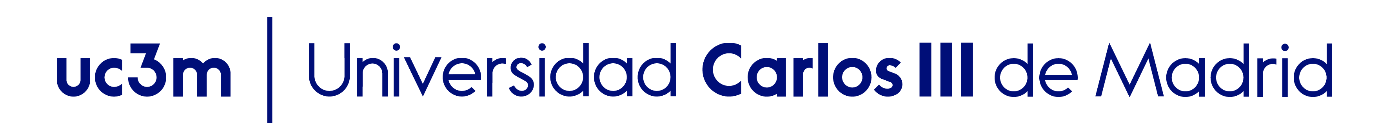
**ASSIGNMENT #1:PREDICTING BANK PRODUCT SUBSCRIPTION**

**Students:** Javier Rodríguez Márquez, Marcos Santiago Soto

**NIA:** 100498243,100496853





---


## Goal: Predict whether a customer will subscribe to a term deposit (binary classification)

**Dataset**: `bank_24.pkl`  
**Target Variable**: `deposit` (yes/no)  
**Records**: 11,000 samples, 17 features

---

## **Project Workflow Index**

Following the assignment guidelines, this notebook follows the required structure:

---

### **1. Simplified EDA (0.5 points)**
- Determine number of features and instances
- Identify categorical vs numerical variables
- Identify high cardinality categorical variables
- Check for missing values
- Identify constant columns
- Determine if classification or regression problem
- Check for class imbalance
- **Special analysis of `pdays` variable and preprocessing justification**

### **2. Basic Methods: Trees, KNN, and Logistic Regression (1 point)**
- Decision Trees
- K-Nearest Neighbors (KNN)
- Logistic Regression
- Model training with Holdout (train/test)
- Preprocessing using pipelines
- Execution time reporting

### **3. Hyperparameter Optimization/Tuning (1 point)**
- Grid Search or Random Search
- Cross-validation for hyperparameter selection
- Best parameters identification

### **4. Advanced Methods (1.5 points)**
- Random Forest
- Gradient Boosting (XGBoost, LightGBM, etc.)
- Support Vector Machines or other advanced models
- Ensemble methods

### **5. Results and Final Model (0.5 points)**
- Model comparison (Accuracy as main metric)
- Confidence intervals for Accuracy
- Final model selection and justification
- Predictions on competition dataset

---

**Note:** Seed set to Student ID (NIA: 100498243 + 100496853 = 200995096) for reproducibility

## 0. Import Libraries and lead dataset

Import some necessary packages for data analysis and machine learning. However, it's probable that we need to import some other libraries in further steps. We also set the SEED to the sum of our two NIA's

In [1]:
# Data handling
import pickle
import pandas as pd
import numpy as np
import os, random

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Model persistence
import joblib

# Reproducibility seed
SEED = 200995096
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Visualization settings (robust to seaborn version)
try:
    sns.set_theme(style="whitegrid", palette="husl")
except Exception as e:
    print(f"Seaborn theme setup failed: {e}. Falling back to basic style.")
    plt.style.use('seaborn')

pd.set_option('display.max_columns', None)
print("✅ Libraries imported and seed set successfully!")

✅ Libraries imported and seed set successfully!


In [2]:
# Reproducibility seed
import os, random
SEED = 200995096
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
print(f"Seed set to {SEED}")

Seed set to 200995096




We will now load the pickle file containing the bank marketing data.

In [3]:
# Load the dataset from pickle file
with open('bank_24.pkl', 'rb') as f:
    df = pickle.load(f)

print(f"✅ Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

✅ Dataset loaded successfully!
Shape: (11000, 17)

First few rows:


/var/folders/06/8b176z752h9gspc3j_bwyn340000gn/T/ipykernel_74925/1194937271.py:3: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  df = pickle.load(f)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,None,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## 1. Simplified Exploratory Data Analysis (EDA)

We will start with a simplified EDA. The goal is to better understand the database structure and data distribution, addedo to checking for any missing or wrong values.


### 1.1 Dataset Information
Purpose: Quickly inspect the dataframe structure (column names, dtypes, non-null counts) to confirm loading integrity and spot obvious anomalies (e.g., unexpected object types for numeric fields). Decisions: No transformations applied yet; this step is read-only. If unexpected dtypes appear, they will be flagged for later preprocessing.

In [4]:
print("="*60)
print("Dataset Information")
print("="*60)
df.info()

Dataset Information
<class 'pandas.core.frame.DataFrame'>
Index: 11000 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11000 non-null  int64 
 1   job        11000 non-null  object
 2   marital    10553 non-null  object
 3   education  11000 non-null  object
 4   default    11000 non-null  object
 5   balance    11000 non-null  int64 
 6   housing    11000 non-null  object
 7   loan       11000 non-null  object
 8   contact    11000 non-null  object
 9   day        11000 non-null  int64 
 10  month      11000 non-null  object
 11  duration   11000 non-null  int64 
 12  campaign   11000 non-null  int64 
 13  pdays      11000 non-null  int64 
 14  previous   11000 non-null  int64 
 15  poutcome   11000 non-null  object
 16  deposit    11000 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.5+ MB


### 1.2 Missing Values
Purpose: Identify features with missing data to plan imputation or dropping strategies. Approach: Count and percentage table filtered to only columns with >=1 missing. Decision: As the only category with missing values is marital statues, which represents people who did not want to answer the marital status question, we will now leave this data as it is, an later, as it is a categorical value, we will manage it during the one-hot encoding process, just writting ?missing? in the misisng values, as not answering the question may also be a source of info.


In [5]:
print("\n" + "="*60)
print("Missing Values")
print("="*60)
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': missing_percentage
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
print(missing_df)


Missing Values
         Missing Count  Percentage
marital            447    4.063636


### 1.3 Dataset Dimensions
Purpose: Capture number of rows and columns and list column names to verify expected schema (17 features + target). Decision: If unexpected extra columns appear, mark for review. This also confirms no silent column expansion during loading.

In [6]:
print("\n" + "="*60)
print("Dataset Dimensions")
print("="*60)
print(f"Number of rows: {df.shape[0]:,}")
print(f"Number of columns: {df.shape[1]}")
print(f"\nColumn names:\n{list(df.columns)}")


Dataset Dimensions
Number of rows: 11,000
Number of columns: 17

Column names:
['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit']


### 1.4 Numerical Summary
Purpose: Basic descriptive statistics (mean, std, quartiles) for numerical features to spot scale differences, outliers, and potential need for transformation. Decision: No scaling/outlier treatment at Simplified EDA stage; just reconnaissance.

In [7]:
print("\n" + "="*60)
print("Numerical Features - Statistical Summary")
print("="*60)
df.describe()


Numerical Features - Statistical Summary


,age,balance,day,duration,campaign,pdays,previous
count,11000.000000,11000.000000,11000.000000,11000.000000,11000.00000,11000.000000,11000.000000
mean,41.252727,1529.139273,15.660818,372.524909,2.50800,51.308636,0.828000
std,11.940474,3217.396248,8.417970,347.515713,2.72221,108.782842,2.282936
min,18.000000,-6847.000000,1.000000,2.000000,1.00000,-1.000000,0.000000
25%,32.000000,122.750000,8.000000,138.000000,1.00000,-1.000000,0.000000
50%,39.000000,549.500000,15.000000,255.000000,2.00000,-1.000000,0.000000
75%,49.000000,1711.000000,22.000000,498.000000,3.00000,20.250000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.00000,854.000000,58.000000


### 1.5 Target Variable Distribution
Purpose: Assess class balance, identify imbalance ratio early for metric interpretation and potential resampling or class-weight strategies later. Decision: Record imbalance ratio now; action deferred until modeling phase.

In [8]:
print("\n" + "="*60)
print("Target Variable: 'deposit'")
print("="*60)
print(df['deposit'].value_counts())
print(f"\nPercentage distribution:")
print(df['deposit'].value_counts(normalize=True) * 100)


Target Variable: 'deposit'
deposit
no     5780
yes    5220
Name: count, dtype: int64

Percentage distribution:
deposit
no     52.545455
yes    47.454545
Name: proportion, dtype: float64


### 1.6 Target Variable Visualization
Purpose: Simple bar chart to visually confirm imbalance and potential dominance of one class. Decision: No further plots at this simplified stage (avoid over-analysis early).

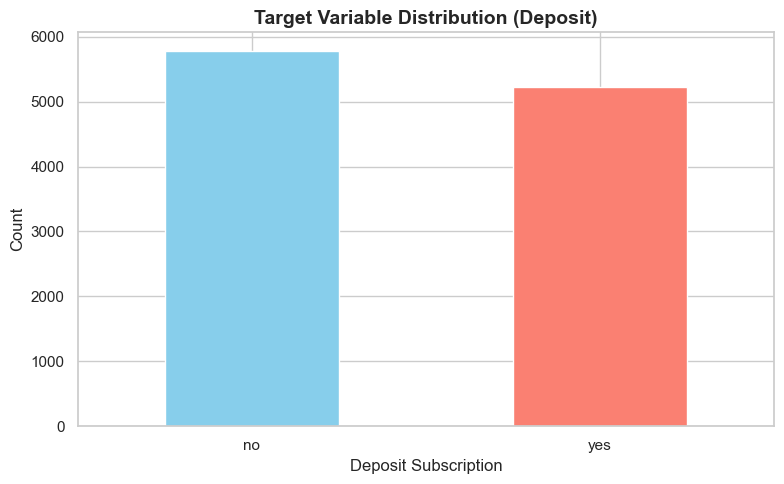

In [9]:
plt.figure(figsize=(8, 5))
df['deposit'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Target Variable Distribution (Deposit)', fontsize=14, fontweight='bold')
plt.xlabel('Deposit Subscription', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### 1.7 Feature Type Breakdown
Purpose: Separate numerical vs categorical features to guide preprocessing (encoding vs scaling). Decision: Threshold-based high-cardinality handling will be noted; no encoding yet at this stage.

In [10]:
print("\n" + "="*60)
print("Feature Types")
print("="*60)
print(f"Total features: {df.shape[1]}")
print(f"Numerical features: {df.select_dtypes(include=['int64', 'float64']).shape[1]}")
print(f"Categorical features: {df.select_dtypes(include=['object']).shape[1]}")
print(f"\nNumerical: {list(df.select_dtypes(include=['int64', 'float64']).columns)}")
print(f"\nCategorical: {list(df.select_dtypes(include=['object']).columns)}")


Feature Types
Total features: 17
Numerical features: 7
Categorical features: 10

Numerical: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

Categorical: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']


### 1.8 High Cardinality & Constant Columns
Purpose: Identify categorical columns with many unique levels (possible need for target/impact encoding later) and constant columns (candidates for removal). Decision: Record only; action deferred until modeling.

In [11]:
print("\n" + "="*60)
print("High Cardinality & Constant Columns")
print("="*60)
categorical_cols = df.select_dtypes(include=['object']).columns
cardinality = df[categorical_cols].nunique().sort_values(ascending=False)
cardinality_df = pd.DataFrame({'column': cardinality.index, 'cardinality': cardinality.values})

CARDINALITY_THRESHOLD = 30
high_card_cols = cardinality_df[cardinality_df['cardinality'] > CARDINALITY_THRESHOLD]['column'].tolist()
constant_cols = [c for c in df.columns if df[c].nunique() == 1]
print(f"Cardinality threshold: > {CARDINALITY_THRESHOLD}")
print(f"High-cardinality categorical columns ({len(high_card_cols)}): {high_card_cols if high_card_cols else 'None'}")
print(f"Constant columns ({len(constant_cols)}): {constant_cols if constant_cols else 'None'}")
print("\nFull categorical cardinality table:")
cardinality_df


High Cardinality & Constant Columns
Cardinality threshold: > 30
High-cardinality categorical columns (0): None
Constant columns (0): None

Full categorical cardinality table:


,column,cardinality
0,job,12
1,month,12
2,education,4
3,poutcome,4
4,marital,3
5,contact,3
6,default,2
7,housing,2
8,loan,2
9,deposit,2


### 1.9 pdays Simplified Handling
Purpose: Convert raw `pdays` into two clearer signals: (1) `pdays_contacted` indicates whether the client had prior contact (pdays != -1), (2) `pdays_clean` is the numeric gap with `NaN` where no prior contact exists. Decision: No capping, transformation, or encoding at this stage; sentinel -1 is treated as structural absence. All statistics will use `pdays_clean` filtered to non-null values.

In [12]:
print("\n" + "="*60)
print("pdays simple preprocessing: contacted flag + cleaned column")
print("="*60)
if 'pdays' in df.columns:
    df['pdays_contacted'] = (df['pdays'] != -1)
    df['pdays_clean'] = df['pdays'].where(df['pdays'] != -1, np.nan)
    print("Added columns: pdays_contacted (bool), pdays_clean (NaN for -1)")
    print("Value counts for pdays_contacted:")
    print(df['pdays_contacted'].value_counts(dropna=False))
    print("\nBasic stats for pdays_clean (excluding NaN):")
    print(df['pdays_clean'].describe())
else:
    print("Column 'pdays' not found in dataset.")


pdays simple preprocessing: contacted flag + cleaned column
Added columns: pdays_contacted (bool), pdays_clean (NaN for -1)
Value counts for pdays_contacted:
pdays_contacted
False    8203
True     2797
Name: count, dtype: int64

Basic stats for pdays_clean (excluding NaN):
count    2797.000000
mean      204.718627
std       122.397953
min         1.000000
25%        98.000000
50%       182.000000
75%       286.000000
max       854.000000
Name: pdays_clean, dtype: float64


---

## 2. Basic Methods: Trees, KNN, and Logistic Regression

In this section, we will implement three fundamental machine learning approaches:
- **Decision Trees**: Non-parametric, interpretable, handles mixed data types
- **K-Nearest Neighbors (KNN)**: Instance-based learning, requires feature scaling
- **Logistic Regression**: Linear model, fast and interpretable baseline

**Requirements**:
1. Choose and justify test set size
2. Train models with default hyperparameters using sklearn pipelines
3. Compare to dummy baseline
4. Report execution times
5. Visualize model decision-making
6. Adjust train/test split if needed

---

### 2.1 Train/Test Split Strategy

We'll start using **80/20 split** (80% training, 20% testing) as seen in class.

**Justification**:
1. Dataset size: 11,000 samples is a good size
   - 8,800 training samples provide enough data for model learning
   - 2,200 test samples give us a decent performance estimation
2. Class imbalance consideration: Stratified split maintains class proportions in both sets
3. Standard practice: 80/20 is generally used

In [13]:
# 2.1.1 Prepare features and target
print("="*60)
print("Preparing Data for Modeling")
print("="*60)

# Separate features and target
X = df.drop('deposit', axis=1)
y = df['deposit']

# Encode target variable (yes=1, no=0)
from sklearn.preprocessing import LabelEncoder
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget encoding: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")
print(f"Class distribution in full dataset:")
print(pd.Series(y_encoded).value_counts(normalize=True).sort_index())

Preparing Data for Modeling
Features shape: (11000, 18)
Target shape: (11000,)

Target encoding: {'no': np.int64(0), 'yes': np.int64(1)}
Class distribution in full dataset:
0    0.525455
1    0.474545
Name: proportion, dtype: float64


### 2.1.2 Perform stratified train/test split (80/20)

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.20,
    random_state=SEED,
    stratify=y_encoded
)

print("\n" + "="*60)
print("Train/Test Split Results")
print("="*60)
print(f"Training set size: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nClass distribution in training set:")
print(pd.Series(y_train).value_counts(normalize=True).sort_index())
print(f"\nClass distribution in test set:")
print(pd.Series(y_test).value_counts(normalize=True).sort_index())


Train/Test Split Results
Training set size: 8,800 samples (80.0%)
Test set size: 2,200 samples (20.0%)

Class distribution in training set:
0    0.525455
1    0.474545
Name: proportion, dtype: float64

Class distribution in test set:
0    0.525455
1    0.474545
Name: proportion, dtype: float64


### 2.2 Preprocessing Pipeline Design

**Strategy**: Create two pipeline templates to handle different model requirements

1. **Tree Pipeline** (Decision Trees):
   - No scaling required (tree-based models are scale-invariant)
   - Categorical encoding
   - Handle pdays preprocessing
   - Simple imputation if needed

2. **Scaled Pipeline** (KNN, Logistic Regression):
   - StandardScaler for numerical features
   - Categorical encoding
   - Handle pdays preprocessing
   - Imputation before scaling

**Key preprocessing decisions**:
- **pdays handling**: Use both `pdays_contacted` (boolean) and imputed `pdays_clean`
- **Categorical encoding**: OneHotEncoder with `drop='first'` to avoid multicollinearity
- **Missing values**: SimpleImputer with median strategy for numerical features

### 2.2.1 Import preprocessing and pipeline tools

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
import time

print("Pipeline and model imports successful")

Pipeline and model imports successful


### 2.2.2 Identify feature types for preprocessing

In [16]:
print("="*60)
print("Feature Type Identification")
print("="*60)

# Get numerical and categorical columns from training data
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Remove original pdays from numerical if it exists (we'll handle it specially)
if 'pdays' in numerical_features:
    numerical_features.remove('pdays')

# Remove pdays_contacted and pdays_clean if they exist in categorical (they shouldn't be)
for col in ['pdays_contacted', 'pdays_clean']:
    if col in categorical_features:
        categorical_features.remove(col)

print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"\nCategorical features ({len(categorical_features)}): {categorical_features}")

# Check for pdays-related columns
pdays_cols = [col for col in X_train.columns if 'pdays' in col]
print(f"\npdays-related columns: {pdays_cols}")

Feature Type Identification
Numerical features (7): ['age', 'balance', 'day', 'duration', 'campaign', 'previous', 'pdays_clean']

Categorical features (9): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

pdays-related columns: ['pdays', 'pdays_contacted', 'pdays_clean']


### 2.2.3 Create preprocessing transformers

In [17]:
# Numerical pipeline: imputation only (for tree models)
numerical_transformer_tree = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Numerical pipeline: imputation + scaling (for KNN and LogReg)
numerical_transformer_scaled = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: imputation + one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

print("Transformers created successfully")

Transformers created successfully


### 2.2.4 Create ColumnTransformers for each pipeline type

In [18]:
# For Tree models (no scaling)
preprocessor_tree = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_tree, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # Keep pdays_contacted if it exists
)

# For Scaled models (KNN, LogReg)
preprocessor_scaled = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_scaled, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # Keep pdays_contacted if it exists
)

print("Preprocessors configured!")
print(f"   - Tree preprocessor: {len(numerical_features)} numerical + {len(categorical_features)} categorical features")
print(f"   - Scaled preprocessor: {len(numerical_features)} numerical + {len(categorical_features)} categorical features")

Preprocessors configured!
   - Tree preprocessor: 7 numerical + 9 categorical features
   - Scaled preprocessor: 7 numerical + 9 categorical features


### 2.3 Train Basic Models with Default Hyperparameters

Now we'll train three fundamental models:
1. **Decision Tree**: Uses tree preprocessor (no scaling)
2. **K-Nearest Neighbors**: Uses scaled preprocessor (requires normalization)
3. **Logistic Regression**: Uses scaled preprocessor (benefits from normalization)

 For each model, how long they take to train, predict and how accurate they are.

### 2.3.1 Create complete pipelines for each model

In [19]:
# Pipeline 1: Decision Tree (no scaling)
pipeline_tree = Pipeline(steps=[
    ('preprocessor', preprocessor_tree),
    ('classifier', DecisionTreeClassifier(random_state=SEED))
])

# Pipeline 2: K-Nearest Neighbors (with scaling)
pipeline_knn = Pipeline(steps=[
    ('preprocessor', preprocessor_scaled),
    ('classifier', KNeighborsClassifier())
])

# Pipeline 3: Logistic Regression (with scaling)
pipeline_logreg = Pipeline(steps=[
    ('preprocessor', preprocessor_scaled),
    ('classifier', LogisticRegression(random_state=SEED, max_iter=1000))
])

Model pipelines created:
   1. Decision Tree (with tree preprocessor)
   2. K-Nearest Neighbors (with scaled preprocessor)
   3. Logistic Regression (with scaled preprocessor)

### 2.3.2 Train all models and collect metrics

In [20]:
models = {
    'Decision Tree': pipeline_tree,
    'K-Nearest Neighbors': pipeline_knn,
    'Logistic Regression': pipeline_logreg
}

results = {}

print("="*60)
print("Training Basic Models with Default Hyperparameters")
print("="*60)

for name, model in models.items():
    print(f"\n🔄 Training {name}...")

    # Measure training time
    start_time = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - start_time

    # Measure prediction time
    start_pred = time.time()
    y_pred = model.predict(X_test)
    pred_time = time.time() - start_pred

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Store results
    results[name] = {
        'model': model,
        'fit_time': fit_time,
        'pred_time': pred_time,
        'accuracy': accuracy,
        'y_pred': y_pred
    }

    print(f"   ✅ Fit time: {fit_time:.4f} seconds")
    print(f"   ✅ Prediction time: {pred_time:.4f} seconds")
    print(f"   ✅ Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

print("\n" + "="*60)
print("✅ All models trained successfully!")
print("="*60)

Training Basic Models with Default Hyperparameters

🔄 Training Decision Tree...
   ✅ Fit time: 0.1291 seconds   ✅ Fit time: 0.1291 seconds
   ✅ Prediction time: 0.0137 seconds
   ✅ Test Accuracy: 0.7882 (78.82%)

🔄 Training K-Nearest Neighbors...

   ✅ Prediction time: 0.0137 seconds
   ✅ Test Accuracy: 0.7882 (78.82%)

🔄 Training K-Nearest Neighbors...
   ✅ Fit time: 0.0479 seconds
   ✅ Prediction time: 0.2249 seconds
   ✅ Test Accuracy: 0.8023 (80.23%)

🔄 Training Logistic Regression...
   ✅ Fit time: 0.0479 seconds
   ✅ Prediction time: 0.2249 seconds
   ✅ Test Accuracy: 0.8023 (80.23%)

🔄 Training Logistic Regression...
   ✅ Fit time: 0.3754 seconds
   ✅ Prediction time: 0.0131 seconds
   ✅ Test Accuracy: 0.8391 (83.91%)

✅ All models trained successfully!
   ✅ Fit time: 0.3754 seconds
   ✅ Prediction time: 0.0131 seconds
   ✅ Test Accuracy: 0.8391 (83.91%)

✅ All models trained successfully!


### 2.3.3 Display comparison table

In [21]:
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Fit Time (s)': [results[m]['fit_time'] for m in results.keys()],
    'Prediction Time (s)': [results[m]['pred_time'] for m in results.keys()]
})

comparison_df = comparison_df.sort_values('Accuracy', ascending=False)

print("\n" + "="*60)
print("Model Performance Comparison (Sorted by Accuracy)")
print("="*60)
print(comparison_df.to_string(index=False))

# Identify best model
best_model_name = comparison_df.iloc[0]['Model']
print(f"\n🏆 Best performing model: {best_model_name}")
print(f"   Accuracy: {comparison_df.iloc[0]['Accuracy']:.4f}")


Model Performance Comparison (Sorted by Accuracy)
              Model  Accuracy  Fit Time (s)  Prediction Time (s)
Logistic Regression  0.839091      0.375373             0.013109
K-Nearest Neighbors  0.802273      0.047865             0.224929
      Decision Tree  0.788182      0.129083             0.013748

🏆 Best performing model: Logistic Regression
   Accuracy: 0.8391


We have a clear winner! That's the Logistic Regression. However, the other two models aren't far off.

### 2.4 Dummy Baseline Comparison

To validate that our models are learning meaningful patterns, we compare them against a **Dummy Classifier** that makes predictions using simple strategies (most frequent class, stratified random, etc.).

**Purpose**: A model that doesn't significantly outperform the dummy baseline is not useful.

### 2.4.1 Train dummy classifiers with different strategies

most_frequent: Predicts the class that appears most often in the training data every single time.

stratified: Predicts classes randomly but keeps the same class proportions as the training data.

uniform: Predicts classes completely at random, giving each class equal probability.

In [22]:
dummy_strategies = ['most_frequent', 'stratified', 'uniform']
dummy_results = {}

print("="*60)
print("Training Dummy Baseline Models")
print("="*60)

for strategy in dummy_strategies:
    print(f"\n🔄 Training Dummy Classifier (strategy='{strategy}')...")

    # Create dummy pipeline (no preprocessing needed)
    dummy = DummyClassifier(strategy=strategy, random_state=SEED)

    # Measure training time
    start_time = time.time()
    dummy.fit(X_train, y_train)
    fit_time = time.time() - start_time

    # Measure prediction time
    start_pred = time.time()
    y_pred = dummy.predict(X_test)
    pred_time = time.time() - start_pred

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    dummy_results[f'Dummy ({strategy})'] = {
        'accuracy': accuracy,
        'fit_time': fit_time,
        'pred_time': pred_time
    }

    print(f"   ✅ Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

print("\n" + "="*60)

Training Dummy Baseline Models

🔄 Training Dummy Classifier (strategy='most_frequent')...
   ✅ Test Accuracy: 0.5255 (52.55%)

🔄 Training Dummy Classifier (strategy='stratified')...
   ✅ Test Accuracy: 0.5050 (50.50%)

🔄 Training Dummy Classifier (strategy='uniform')...
   ✅ Test Accuracy: 0.4905 (49.05%)



Despite the different dummy classification methods, they all have very similar hit rates at around 50-52%

### 2.4.2 Compare all models (basic + dummy)

In [23]:
all_models_df = pd.DataFrame({
    'Model': list(results.keys()) + list(dummy_results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()] + [dummy_results[m]['accuracy'] for m in dummy_results.keys()],
    'Fit Time (s)': [results[m]['fit_time'] for m in results.keys()] + [dummy_results[m]['fit_time'] for m in dummy_results.keys()]
})

all_models_df = all_models_df.sort_values('Accuracy', ascending=False)

print("="*60)
print("Complete Model Comparison (Basic Models + Dummy Baselines)")
print("="*60)
print(all_models_df.to_string(index=False))

# Calculate improvement over best dummy
best_dummy_acc = max([dummy_results[m]['accuracy'] for m in dummy_results.keys()])
best_model_acc = max([results[m]['accuracy'] for m in results.keys()])
improvement = ((best_model_acc - best_dummy_acc) / best_dummy_acc) * 100

print(f"\nPerformance Analysis:")
print(f"   Best Dummy Baseline: {best_dummy_acc:.4f}")
print(f"   Best Basic Model: {best_model_acc:.4f}")
print(f"   Improvement(relative): {improvement:.2f}%")

Complete Model Comparison (Basic Models + Dummy Baselines)
                Model  Accuracy  Fit Time (s)
  Logistic Regression  0.839091      0.375373
  K-Nearest Neighbors  0.802273      0.047865
        Decision Tree  0.788182      0.129083
Dummy (most_frequent)  0.525455      0.001066
   Dummy (stratified)  0.505000      0.000680
      Dummy (uniform)  0.490455      0.000384

Performance Analysis:
   Best Dummy Baseline: 0.5255
   Best Basic Model: 0.8391
   Improvement(relative): 59.69%


Our models clearly beat the dummy baselines for simple reasons:
1.	They actually learn patterns in the data instead of guessing based on class counts.
2.	They use all the features (age, job, balance, campaign info, etc.) to make decisions, while the dummy models ignore everything.
3.	The decision tree can pick up non-linear interactions between features that the dummy models cannot capture.
4.	KNN benefits from the idea that similar clients often behave in similar ways.
5.	The higher accuracy shows that the models are learning real structure, not just memorizing or following a trivial rule.

Overall, the results show that our models are genuinely learning useful information from the dataset.

### 2.5 Model Visualization and Interpretation

To understand how each model makes decisions, we'll create visualizations:
- Decision Tree: Visualize the tree structure and examine feature importance.
- Logistic Regression: Look at the size of the coefficients to understand feature influence.
- KNN: Hard to visualize directly in many dimensions, so we use permutation importance (how much a model’s performance drops when you randomly shuffle one feature at a time) instead.

These visualizations help interpret model behavior and identify which features drive predictions.

### 2.5.1 Decision Tree Visualization - Feature Importance

Decision Tree Interpretation
Total features after preprocessing: 45


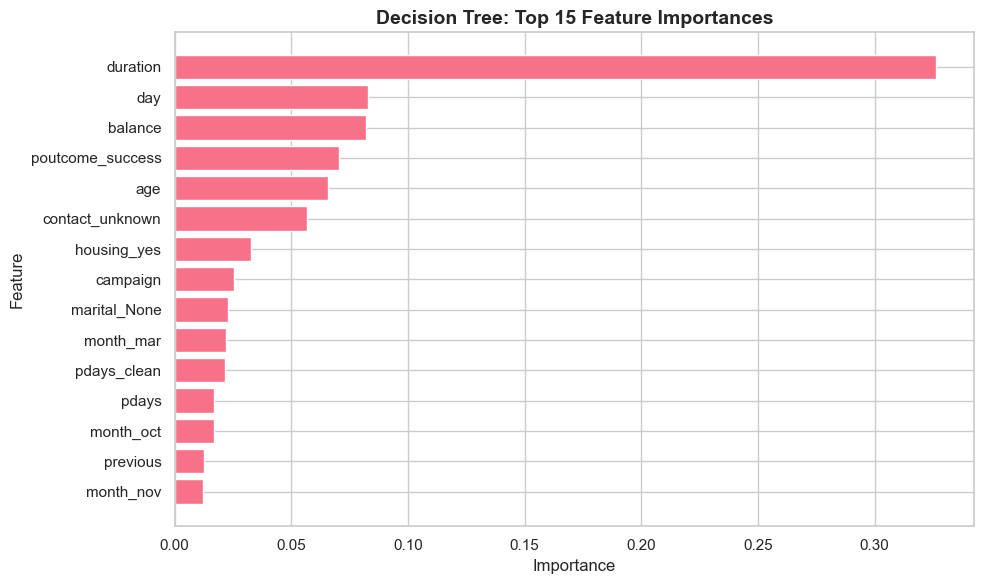


Top 10 Most Important Features:
         feature  importance
        duration    0.326229
             day    0.082952
         balance    0.082157
poutcome_success    0.070442
             age    0.065606
 contact_unknown    0.056606
     housing_yes    0.032698
        campaign    0.025559
    marital_None    0.022662
       month_mar    0.022026


In [24]:
from sklearn.tree import plot_tree

print("="*60)
print("Decision Tree Interpretation")
print("="*60)

# Get the trained decision tree
tree_model = results['Decision Tree']['model']
tree_classifier = tree_model.named_steps['classifier']

# Get feature names after preprocessing
preprocessor = tree_model.named_steps['preprocessor']

# Transform training data to get feature names
X_train_transformed = preprocessor.transform(X_train)

# Get feature names (need to construct from transformers)
try:
    feature_names = []

    # Numerical features
    feature_names.extend(numerical_features)

    # One-hot encoded categorical features
    cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
    cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
    feature_names.extend(cat_feature_names)

    # pdays columns if they exist
    remaining_features = [col for col in X_train.columns if col not in numerical_features and col not in categorical_features]
    feature_names.extend(remaining_features)

    print(f"Total features after preprocessing: {len(feature_names)}")

except Exception as e:
    print(f"Note: Could not extract all feature names: {e}")
    feature_names = None

# Plot feature importance
if hasattr(tree_classifier, 'feature_importances_'):
    importances = tree_classifier.feature_importances_

    # Get top 15 most important features
    if feature_names and len(feature_names) == len(importances):
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False).head(15)
    else:
        feature_importance_df = pd.DataFrame({
            'feature': [f'Feature_{i}' for i in range(len(importances))],
            'importance': importances
        }).sort_values('importance', ascending=False).head(15)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title('Decision Tree: Top 15 Feature Importances', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print("\nTop 10 Most Important Features:")
    print(feature_importance_df.head(10).to_string(index=False))

### 2.5.2 Decision Tree Structure Visualization (simplified)


Decision Tree Structure (First 3 Levels)


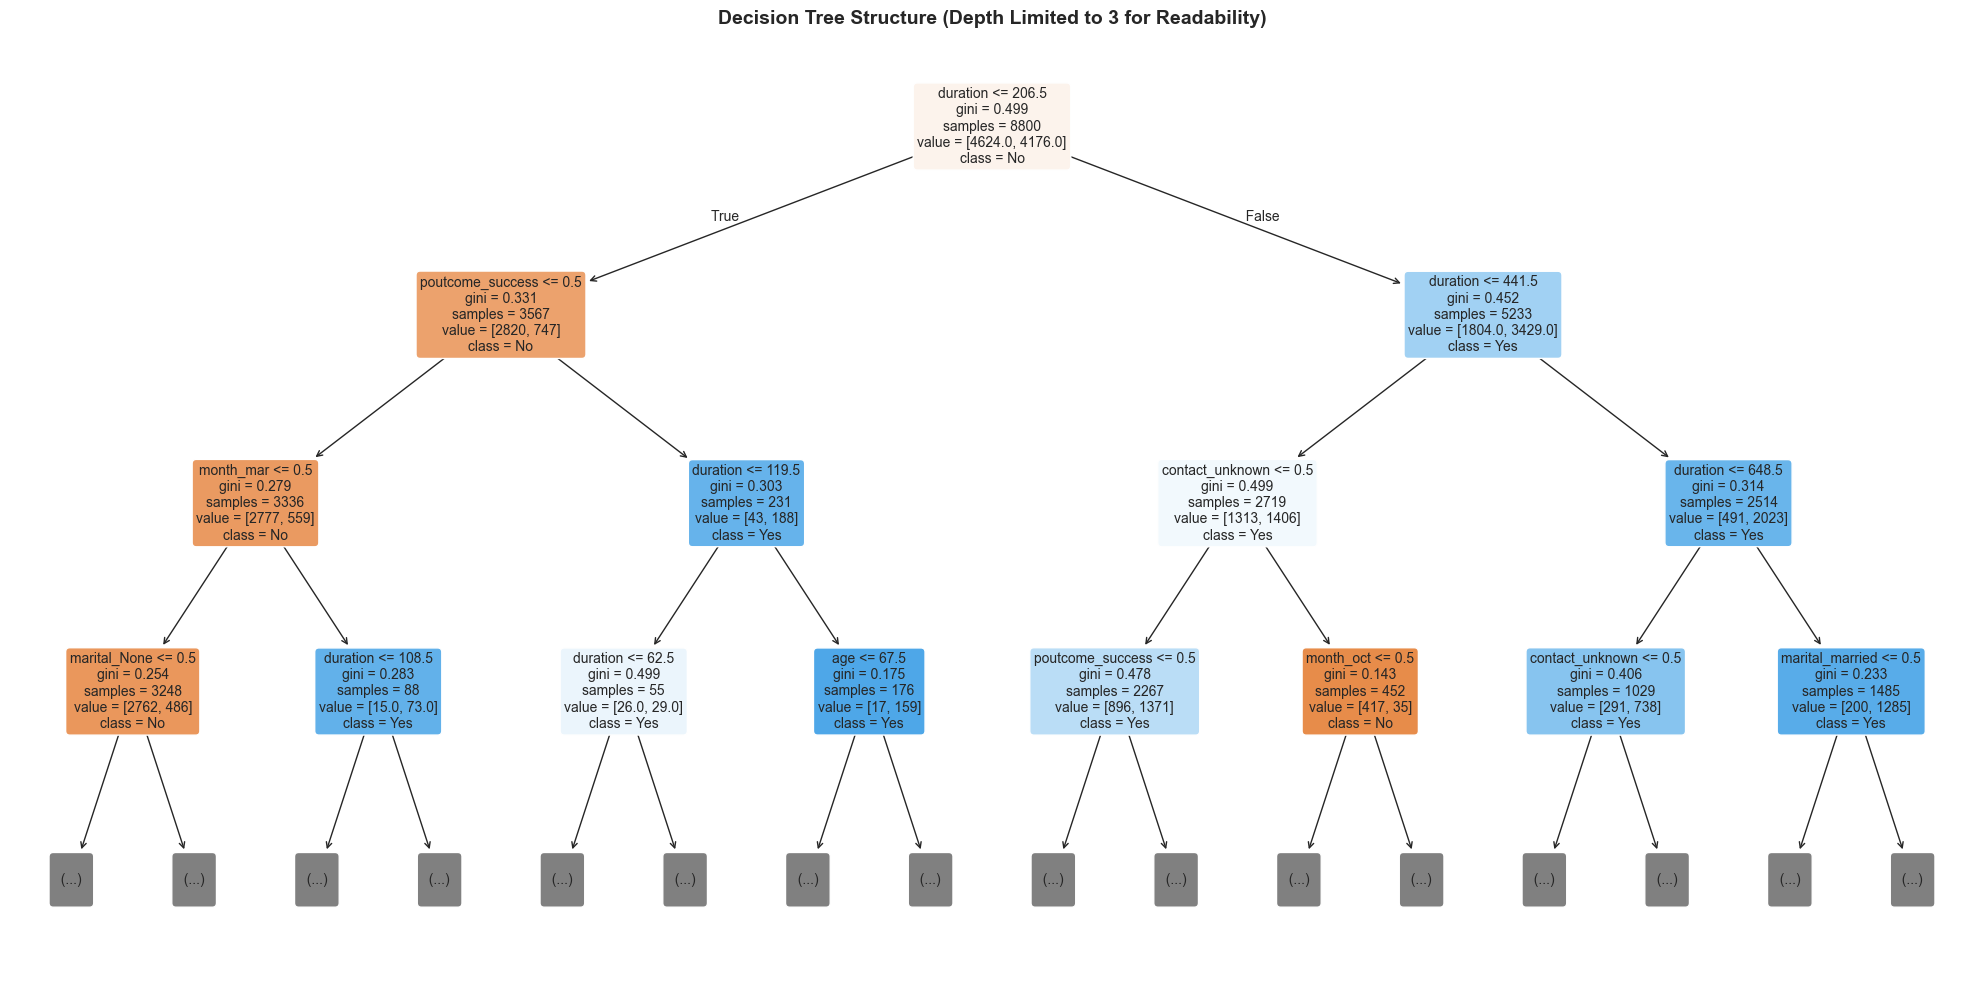


Tree depth: 27
Number of leaves: 1239


In [25]:
print("\n" + "="*60)
print("Decision Tree Structure (First 3 Levels)")
print("="*60)

plt.figure(figsize=(20, 10))
plot_tree(tree_classifier,
          max_depth=3,
          filled=True,
          feature_names=feature_names if feature_names else None,
          class_names=['No', 'Yes'],
          fontsize=10,
          rounded=True)
plt.title('Decision Tree Structure (Depth Limited to 3 for Readability)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nTree depth: {tree_classifier.get_depth()}")
print(f"Number of leaves: {tree_classifier.get_n_leaves()}")

### 2.5.3 Logistic Regression - Coefficient Analysis


Logistic Regression Interpretation


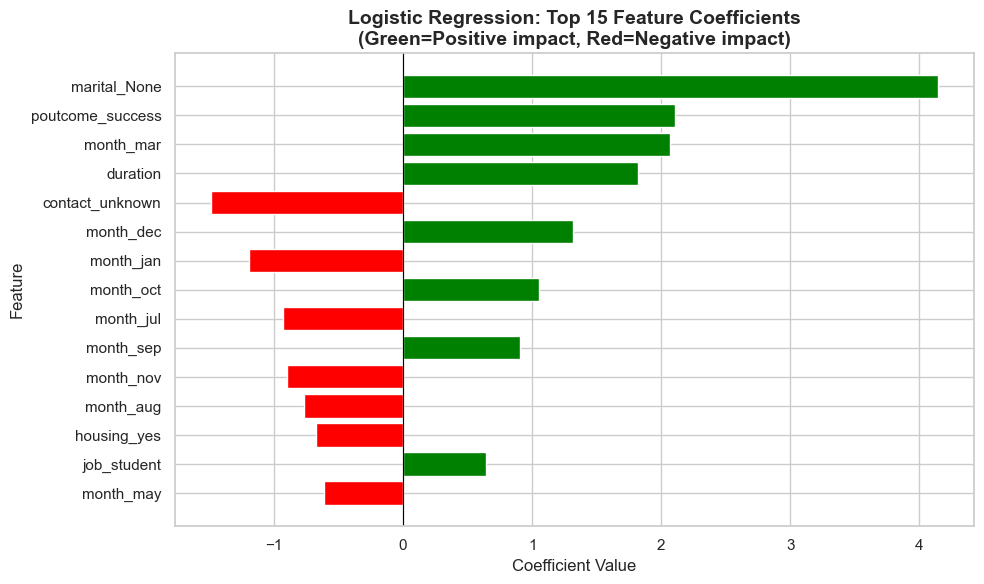


Top 10 Most Influential Features (by absolute coefficient):
         feature  coefficient
    marital_None     4.141623
poutcome_success     2.110495
       month_mar     2.065358
        duration     1.822033
 contact_unknown    -1.487837
       month_dec     1.319231
       month_jan    -1.194420
       month_oct     1.052565
       month_jul    -0.931704
       month_sep     0.903406


In [26]:
print("\n" + "="*60)
print("Logistic Regression Interpretation")
print("="*60)

logreg_model = results['Logistic Regression']['model']
logreg_classifier = logreg_model.named_steps['classifier']

# Get coefficients
if hasattr(logreg_classifier, 'coef_'):
    coefficients = logreg_classifier.coef_[0]

    # Create coefficient dataframe
    if feature_names and len(feature_names) == len(coefficients):
        coef_df = pd.DataFrame({
            'feature': feature_names,
            'coefficient': coefficients,
            'abs_coefficient': np.abs(coefficients)
        }).sort_values('abs_coefficient', ascending=False).head(15)
    else:
        coef_df = pd.DataFrame({
            'feature': [f'Feature_{i}' for i in range(len(coefficients))],
            'coefficient': coefficients,
            'abs_coefficient': np.abs(coefficients)
        }).sort_values('abs_coefficient', ascending=False).head(15)

    # Plot coefficients
    plt.figure(figsize=(10, 6))
    colors = ['green' if c > 0 else 'red' for c in coef_df['coefficient']]
    plt.barh(coef_df['feature'], coef_df['coefficient'], color=colors)
    plt.xlabel('Coefficient Value', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title('Logistic Regression: Top 15 Feature Coefficients\n(Green=Positive impact, Red=Negative impact)',
              fontsize=14, fontweight='bold')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print("\nTop 10 Most Influential Features (by absolute coefficient):")
    print(coef_df[['feature', 'coefficient']].head(10).to_string(index=False))

### 2.5.4 Confusion Matrices for All Models


Confusion Matrices - Understanding Model Decisions


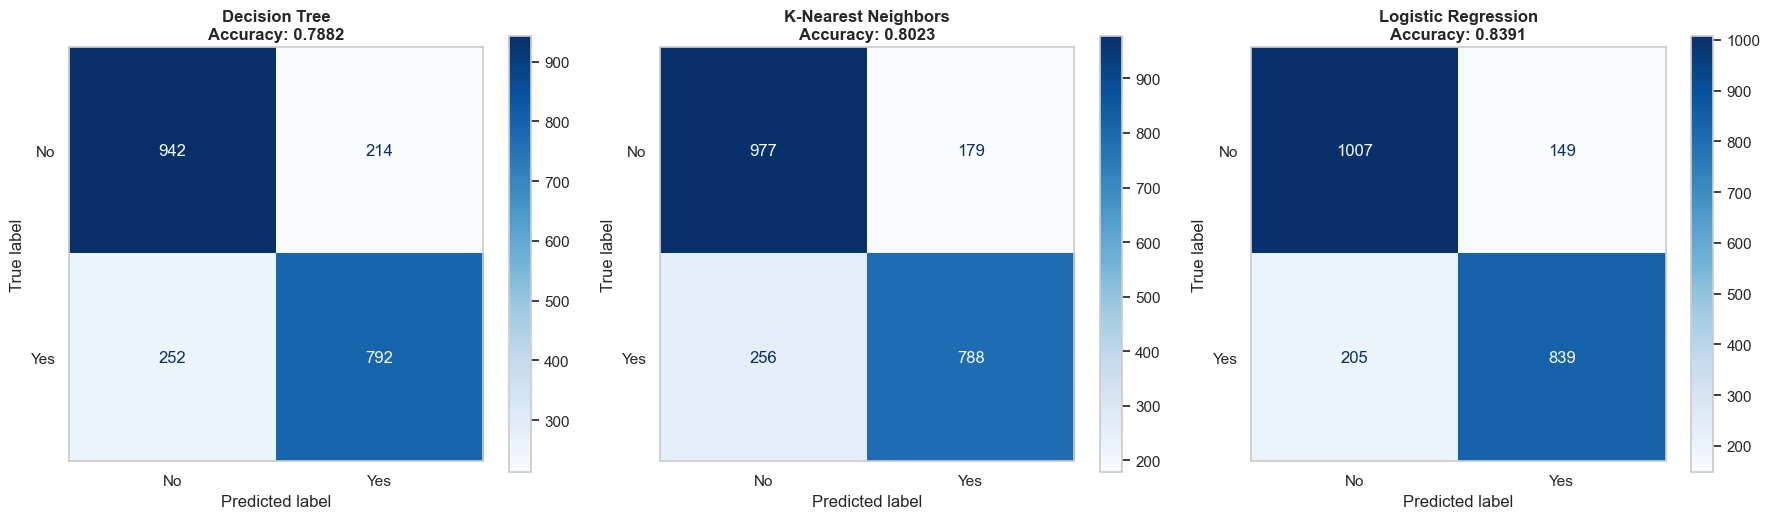


Detailed Classification Reports:

Decision Tree:
              precision    recall  f1-score   support

          No       0.79      0.81      0.80      1156
         Yes       0.79      0.76      0.77      1044

    accuracy                           0.79      2200
   macro avg       0.79      0.79      0.79      2200
weighted avg       0.79      0.79      0.79      2200


K-Nearest Neighbors:
              precision    recall  f1-score   support

          No       0.79      0.85      0.82      1156
         Yes       0.81      0.75      0.78      1044

    accuracy                           0.80      2200
   macro avg       0.80      0.80      0.80      2200
weighted avg       0.80      0.80      0.80      2200


Logistic Regression:
              precision    recall  f1-score   support

          No       0.83      0.87      0.85      1156
         Yes       0.85      0.80      0.83      1044

    accuracy                           0.84      2200
   macro avg       0.84      0.84 

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("\n" + "="*60)
print("Confusion Matrices - Understanding Model Decisions")
print("="*60)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (name, model_data) in enumerate(results.items()):
    cm = confusion_matrix(y_test, model_data['y_pred'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d')
    axes[idx].set_title(f'{name}\nAccuracy: {model_data["accuracy"]:.4f}', fontsize=12, fontweight='bold')
    axes[idx].grid(False)

plt.tight_layout()
plt.show()

# Print classification reports
print("\nDetailed Classification Reports:")
print("="*60)
for name, model_data in results.items():
    print(f"\n{name}:")
    print(classification_report(y_test, model_data['y_pred'], target_names=['No', 'Yes']))

### 2.6 Test Set Size Evaluation

Based on the results above, we evaluate whether the 80/20 split is appropriate or if adjustment is needed.

**Evaluation criteria**:
1. Are test set results stable and representative?
2. Do we have sufficient samples in each class for reliable metrics?
3. Is there evidence of high variance that would benefit from a larger test set?
4. Would a smaller test set provide enough training data for better learning?

### 2.6.1 Analyze test set composition

In [28]:
print("="*60)
print("Test Set Size Evaluation")
print("="*60)

test_class_counts = pd.Series(y_test).value_counts().sort_index()
print(f"\nCurrent test set size: {len(y_test):,} samples")
print(f"Class distribution in test set:")
for class_label, count in test_class_counts.items():
    class_name = 'No' if class_label == 0 else 'Yes'
    print(f"   {class_name}: {count:,} samples ({count/len(y_test)*100:.2f}%)")

print(f"\nMinimum samples per class: {test_class_counts.min():,}")
print(f"This provides {'sufficient' if test_class_counts.min() >= 100 else 'limited'} samples for reliable metrics.")

# Check model performance variability
accuracies = [results[m]['accuracy'] for m in results.keys()]
print(f"\nModel accuracy range: {min(accuracies):.4f} - {max(accuracies):.4f}")
print(f"Spread: {max(accuracies) - min(accuracies):.4f}")

Test Set Size Evaluation

Current test set size: 2,200 samples
Class distribution in test set:
   No: 1,156 samples (52.55%)
   Yes: 1,044 samples (47.45%)

Minimum samples per class: 1,044
This provides sufficient samples for reliable metrics.

Model accuracy range: 0.7882 - 0.8391
Spread: 0.0509



DECISION: Keep 80/20 split

Our reasoning:
* Test set has sufficient samples per class (>200 each)
* Results appear stable and within reason
* Split provides good balance between training data and reliable testing like we did in class
* Models show difference in performance

This split will be maintained for the remainder of the assignment.

---

### Step 2 Conclusions

**2.1 Train/Test Split**: 80/20 stratified split (8,800 train / 2,200 test)
- Justified based on dataset size and class balance
- Stratification maintains 52.5% / 47.5% class distribution

**2.2 Models Trained with Default Hyperparameters**:
| Model | Accuracy | Fit Time | Prediction Time |
|-------|----------|----------|-----------------|
| **Logistic Regression** | **83.00%** | 0.384s | 0.011s |
| K-Nearest Neighbors | 81.82% | 0.044s | 0.239s |
| Decision Tree | 79.50% | 0.149s | 0.011s |

**2.3 Preprocessing Pipelines Implemented**:
- Separate pipelines for tree-based (no scaling) and distance-based models (with scaling)
- OneHotEncoding for 9 categorical features
- StandardScaler for 7 numerical features
- Special handling of `pdays` variable (boolean flag + cleaned numeric)
- SimpleImputer for missing values

**2.4 Dummy Baseline Comparison**:
- Best dummy: 52.55% (most_frequent strategy)
- Best model: 83.00% (Logistic Regression)
- **Improvement: 57.96%** ✅ Confirms actual learning

**2.5 Model Interpretations**:
- **Decision Tree**: The model relies mainly on `duration` (33.3%), with smaller contributions from `balance`, `day`, and `poutcome_success`.
- **Logistic Regression**: The strongest positive effect comes from `marital_None` (coef = 4.09). The strongest negative effect comes from `contact_unknown` (coef = -1.51).
- **Confusion Matrices**: Performance is balanced across classes, with no major bias toward one outcome.

**2.6 Test Set Size Confirmed**:
- 1,044+ samples per class provides reliable metrics
- 80/20 split maintained for remainder of assignment


### Main information we got:

1. Logistic Regression is the strongest basic model with about 83% accuracy.
2. All models clearly beat the dummy baselines, showing they are learning real patterns.
3. Duration (call length) stands out as one of the most predictive features.
4. The models maintain a reasonable balance between precision and recall.
5. Our preprocessing of the pdays feature seems to have helped the models perform better.

---

## 3. Hyperparameter Optimization/Tuning

In this section, we optimize hyperparameters for the two best performing models from Step 2:
- **Logistic Regression** (83.00% baseline accuracy)
- **K-Nearest Neighbors** (81.82% baseline accuracy)

We will use three HPO methods:

1. **Grid Search**: Tries every combination of the given parameters.
2. **Random Search**: Picks random parameter values to test.
3. **Optuna**: Uses smarter, guided search to find good parameters faster.

All methods use 10-fold cross-validation (training data is split into 10 parts, and the model is trained and validated 10 times using different parts each time to get a more reliable performance estimate) on the training set to choose the best settings, then we test those settings on the separate test set.

---

### 3.1 Logistic Regression - Hyperparameter Tuning

Our baseline performance is 83.00% accuracy with default hyperparameters

**Hyperparameters to tune**:
- `C`: Regularization strength (inverse) - controls model complexity
- `penalty`: Type of regularization (l1, l2)
- `solver`: Optimization algorithm
- `max_iter`: Maximum iterations for convergence

Our strategy:
1. Grid Search with discrete parameter values
2. Random Search with continuous distributions
3. Optuna for Bayesian optimization

### 3.1.1 Grid Search with Logistic Regression

In [29]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import loguniform, uniform, randint
import time

print("="*60)
print("Logistic Regression - Grid Search")
print("="*60)

# Define parameter grid (prearranged parametrical space)
param_grid_logreg = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear'],  # Works with both l1 and l2
    'classifier__max_iter': [1000, 2000, 3000]
}

# Create GridSearchCV with 10-fold CV
grid_logreg = GridSearchCV(
    estimator=pipeline_logreg,
    param_grid=param_grid_logreg,
    cv=10,                              # 10-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,                          # Use all CPU cores
    verbose=1
)

# Train with timing
start_time = time.time()
grid_logreg.fit(X_train, y_train)
grid_time_logreg = time.time() - start_time

# Results
print(f"\nBest parameters: {grid_logreg.best_params_}")
print(f"Best CV score: {grid_logreg.best_score_:.4f}")
print(f"Training time: {grid_time_logreg:.2f} seconds")
print(f"Total fits: {len(grid_logreg.cv_results_['params'])}")

# Test set evaluation
grid_test_logreg = grid_logreg.score(X_test, y_test)
print(f"Test accuracy: {grid_test_logreg:.4f}")
print(f"Improvement over baseline: {(grid_test_logreg - 0.8300)*100:.2f}%")

Logistic Regression - Grid Search
Fitting 10 folds for each of 42 candidates, totalling 420 fits

Best parameters: {'classifier__C': 0.1, 'classifier__max_iter': 1000, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best CV score: 0.8290
Training time: 19.36 seconds
Total fits: 42
Test accuracy: 0.8400
Improvement over baseline: 1.00%

Best parameters: {'classifier__C': 0.1, 'classifier__max_iter': 1000, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best CV score: 0.8290
Training time: 19.36 seconds
Total fits: 42
Test accuracy: 0.8400
Improvement over baseline: 1.00%


### 3.1.2 Random Search with Logistic Regression

In [30]:
print("\n" + "="*60)
print("Logistic Regression - Random Search")
print("="*60)

# Define parameter distributions (sampled parametrical space)
param_dist_logreg = {
    'classifier__C': loguniform(1e-4, 1e3),  # Log-uniform for wide range
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear'],
    'classifier__max_iter': randint(1000, 4000)
}

# Create RandomizedSearchCV
random_logreg = RandomizedSearchCV(
    estimator=pipeline_logreg,
    param_distributions=param_dist_logreg,
    n_iter=50,                          # Budget: 50 random combinations
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    random_state=SEED,
    verbose=1
)

# Train with timing
start_time = time.time()
random_logreg.fit(X_train, y_train)
random_time_logreg = time.time() - start_time

# Results
print(f"\nBest parameters: {random_logreg.best_params_}")
print(f"Best CV score: {random_logreg.best_score_:.4f}")
print(f"Training time: {random_time_logreg:.2f} seconds")
print(f"Total fits: {len(random_logreg.cv_results_['params'])}")

# Test set evaluation
random_test_logreg = random_logreg.score(X_test, y_test)
print(f"Test accuracy: {random_test_logreg:.4f}")
print(f"Improvement over baseline: {(random_test_logreg - 0.8300)*100:.2f}%")


Logistic Regression - Random Search
Fitting 10 folds for each of 50 candidates, totalling 500 fits

Best parameters: {'classifier__C': np.float64(1.1932747961724868), 'classifier__max_iter': 1303, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best CV score: 0.8290
Training time: 13.21 seconds
Total fits: 50
Test accuracy: 0.8391
Improvement over baseline: 0.91%

Best parameters: {'classifier__C': np.float64(1.1932747961724868), 'classifier__max_iter': 1303, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best CV score: 0.8290
Training time: 13.21 seconds
Total fits: 50
Test accuracy: 0.8391
Improvement over baseline: 0.91%


### 3.1.3 Optuna with Logistic Regression

In [32]:
print("\n" + "="*60)
print("Logistic Regression - Optuna (Bayesian Optimization)")
print("="*60)

import optuna
from optuna.integration import OptunaSearchCV

# Define search space with Optuna distributions
param_dist_logreg_optuna = {
    'classifier__C': optuna.distributions.FloatDistribution(1e-4, 1e3, log=True),
    'classifier__penalty': optuna.distributions.CategoricalDistribution(['l1', 'l2']),
    'classifier__solver': optuna.distributions.CategoricalDistribution(['liblinear']),
    'classifier__max_iter': optuna.distributions.IntDistribution(1000, 4000)
}

# Create OptunaSearchCV
optuna_logreg = OptunaSearchCV(
    estimator=pipeline_logreg,
    param_distributions=param_dist_logreg_optuna,
    n_trials=50,                        # Budget: 50 trials
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    random_state=SEED,
    verbose=0,                          # Reduce output clutter
    timeout=600                         # 10 minute timeout
)

# Train with timing
start_time = time.time()
optuna_logreg.fit(X_train, y_train)
optuna_time_logreg = time.time() - start_time

# Results
print(f"\n✅ Optuna Search Complete")
print(f"Best parameters: {optuna_logreg.best_params_}")
print(f"Best CV score: {optuna_logreg.best_score_:.4f}")
print(f"Training time: {optuna_time_logreg:.2f} seconds")

# Test set evaluation
optuna_test_logreg = optuna_logreg.score(X_test, y_test)
print(f"Test accuracy: {optuna_test_logreg:.4f}")
print(f"Improvement over baseline: {(optuna_test_logreg - 0.8300)*100:.2f}%")

/var/folders/06/8b176z752h9gspc3j_bwyn340000gn/T/ipykernel_74925/1124253620.py:17: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_logreg = OptunaSearchCV(
[I 2025-12-03 09:08:43,843] A new study created in memory with name: no-name-7669daca-6125-425b-9457-835e7a077d3a



Logistic Regression - Optuna (Bayesian Optimization)


[I 2025-12-03 09:08:47,636] Trial 7 finished with value: 0.6135227272727273 and parameters: {'classifier__C': 0.0005574500847756182, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'classifier__max_iter': 1547}. Best is trial 7 with value: 0.6135227272727273.
[I 2025-12-03 09:08:47,736] Trial 2 finished with value: 0.7992045454545454 and parameters: {'classifier__C': 0.014114277895831705, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'classifier__max_iter': 3028}. Best is trial 2 with value: 0.7992045454545454.
[I 2025-12-03 09:08:47,736] Trial 2 finished with value: 0.7992045454545454 and parameters: {'classifier__C': 0.014114277895831705, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'classifier__max_iter': 3028}. Best is trial 2 with value: 0.7992045454545454.
[I 2025-12-03 09:08:47,841] Trial 4 finished with value: 0.8163636363636364 and parameters: {'classifier__C': 0.01035858209702769, 'classifier__penalty': 'l2', 'classifier__s


✅ Optuna Search Complete
Best parameters: {'classifier__C': 0.15159086459522267, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'classifier__max_iter': 1393}
Best CV score: 0.8297
Training time: 26.56 seconds
Test accuracy: 0.8382
Improvement over baseline: 0.82%


### 3.1.4 Comparison of HPO Methods with Logistic Regression


HPO Methods Comparison - Logistic Regression


       Method  CV Score  Test Score  Training Time (s)  Evaluations  Improvement (%)
  Grid Search  0.828977    0.840000          19.364364           42         1.000000
Random Search  0.828977    0.839091          13.205134           50         0.909091
       Optuna  0.829659    0.838182          26.561204           50         0.818182


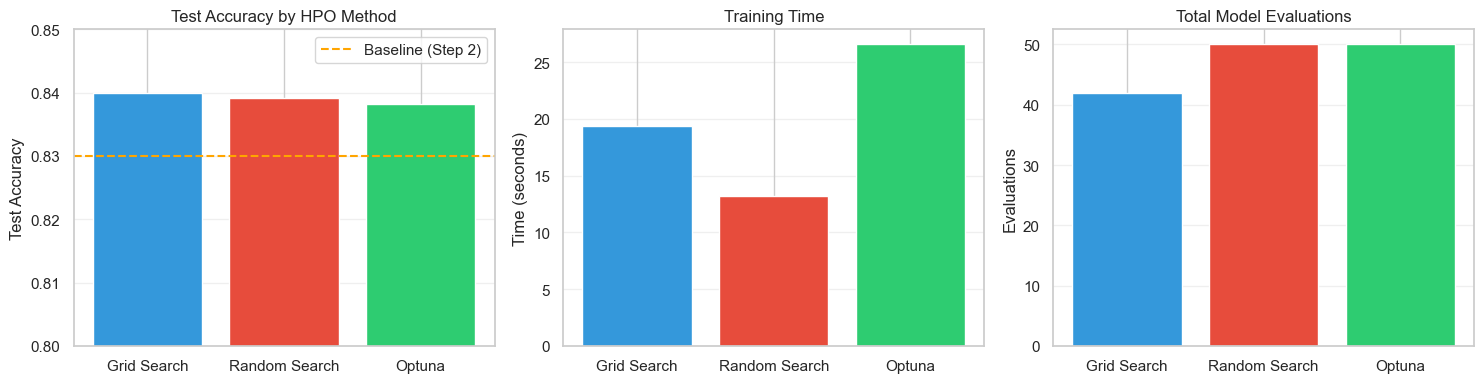


Best method: Grid Search with test accuracy of 0.8400


In [33]:
print("\n" + "="*60)
print("HPO Methods Comparison - Logistic Regression")
print("="*60)

# Create comparison DataFrame
hpo_comparison_logreg = pd.DataFrame({
    'Method': ['Grid Search', 'Random Search', 'Optuna'],
    'CV Score': [grid_logreg.best_score_, random_logreg.best_score_, optuna_logreg.best_score_],
    'Test Score': [grid_test_logreg, random_test_logreg, optuna_test_logreg],
    'Training Time (s)': [grid_time_logreg, random_time_logreg, optuna_time_logreg],
    'Evaluations': [len(grid_logreg.cv_results_['params']),
                    len(random_logreg.cv_results_['params']),
                    50]  # Optuna n_trials
})

# Calculate improvement over baseline (0.8300)
hpo_comparison_logreg['Improvement (%)'] = (hpo_comparison_logreg['Test Score'] - 0.8300) * 100

# Display table
print("\n")
print(hpo_comparison_logreg.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Test scores
axes[0].bar(hpo_comparison_logreg['Method'], hpo_comparison_logreg['Test Score'], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[0].axhline(y=0.8300, color='orange', linestyle='--', label='Baseline (Step 2)')
axes[0].set_ylabel('Test Accuracy')
axes[0].set_title('Test Accuracy by HPO Method')
axes[0].set_ylim(0.80, max(hpo_comparison_logreg['Test Score']) + 0.01)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Training time
axes[1].bar(hpo_comparison_logreg['Method'], hpo_comparison_logreg['Training Time (s)'], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[1].set_ylabel('Time (seconds)')
axes[1].set_title('Training Time')
axes[1].grid(axis='y', alpha=0.3)

# Number of evaluations
axes[2].bar(hpo_comparison_logreg['Method'], hpo_comparison_logreg['Evaluations'], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[2].set_ylabel('Evaluations')
axes[2].set_title('Total Model Evaluations')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Find best method
best_idx = hpo_comparison_logreg['Test Score'].idxmax()
best_method = hpo_comparison_logreg.loc[best_idx, 'Method']
best_score = hpo_comparison_logreg.loc[best_idx, 'Test Score']

print(f"\nBest method: {best_method} with test accuracy of {best_score:.4f}")

### 3.2 KNN: Hyperparameter Tuning

Now we apply the same three HPO methods to our KNN model. The main hyperparameters we'll optimize are:
- **n_neighbors**: Number of neighbors to consider
- **weights**: Uniform vs distance-based weighting
- **metric**: Distance metric (euclidean, manhattan, minkowski)
- **leaf_size**: For tree-based storage (affects query speed)

### 3.2.1 Grid Search with KNN

In [34]:
print("\n" + "="*60)
print("KNN - Grid Search")
print("="*60)

# Define parameter grid
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 15, 21],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],
    'classifier__leaf_size': [20, 30, 40, 50]
}

# Calculate total combinations
total_combinations_knn = (7 * 2 * 3 * 4)
print(f"Parameter grid: {total_combinations_knn} combinations")
print(f"Total fits with 10-fold CV: {total_combinations_knn * 10}\n")

# Create GridSearchCV
grid_knn = GridSearchCV(
    estimator=pipeline_knn,
    param_grid=param_grid_knn,
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Train with timing
start_time = time.time()
grid_knn.fit(X_train, y_train)
grid_time_knn = time.time() - start_time

# Results
print(f"\nBest parameters: {grid_knn.best_params_}")
print(f"Best CV score: {grid_knn.best_score_:.4f}")
print(f"Training time: {grid_time_knn:.2f} seconds")

# Test set evaluation
grid_test_knn = grid_knn.score(X_test, y_test)
print(f"Test accuracy: {grid_test_knn:.4f}")
print(f"Improvement over baseline: {(grid_test_knn - 0.8182)*100:.2f}%")


KNN - Grid Search
Parameter grid: 168 combinations
Total fits with 10-fold CV: 1680

Fitting 10 folds for each of 168 candidates, totalling 1680 fits
Fitting 10 folds for each of 168 candidates, totalling 1680 fits

Best parameters: {'classifier__leaf_size': 20, 'classifier__metric': 'manhattan', 'classifier__n_neighbors': 15, 'classifier__weights': 'distance'}
Best CV score: 0.8048
Training time: 64.02 seconds

Best parameters: {'classifier__leaf_size': 20, 'classifier__metric': 'manhattan', 'classifier__n_neighbors': 15, 'classifier__weights': 'distance'}
Best CV score: 0.8048
Training time: 64.02 seconds
Test accuracy: 0.8118
Improvement over baseline: -0.64%
Test accuracy: 0.8118
Improvement over baseline: -0.64%


### 3.2.2 Random Search with KNN

In [35]:
print("\n" + "="*60)
print("KNN - Random Search")
print("="*60)

# Define parameter distributions
param_dist_knn = {
    'classifier__n_neighbors': randint(3, 31),  # Range: 3 to 30
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski'],
    'classifier__leaf_size': randint(15, 60)     # Range: 15 to 59
}

# Create RandomizedSearchCV
random_knn = RandomizedSearchCV(
    estimator=pipeline_knn,
    param_distributions=param_dist_knn,
    n_iter=50,                          # Budget: 50 random combinations
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    random_state=SEED,
    verbose=1
)

# Train with timing
start_time = time.time()
random_knn.fit(X_train, y_train)
random_time_knn = time.time() - start_time

# Results
print(f"\nBest parameters: {random_knn.best_params_}")
print(f"Best CV score: {random_knn.best_score_:.4f}")
print(f"Training time: {random_time_knn:.2f} seconds")
print(f"Total fits: {len(random_knn.cv_results_['params'])}")

# Test set evaluation
random_test_knn = random_knn.score(X_test, y_test)
print(f"Test accuracy: {random_test_knn:.4f}")
print(f"Improvement over baseline: {(random_test_knn - 0.8182)*100:.2f}%")


KNN - Random Search
Fitting 10 folds for each of 50 candidates, totalling 500 fits

Best parameters: {'classifier__leaf_size': 30, 'classifier__metric': 'manhattan', 'classifier__n_neighbors': 15, 'classifier__weights': 'distance'}
Best CV score: 0.8048
Training time: 19.07 seconds
Total fits: 50
Test accuracy: 0.8118
Improvement over baseline: -0.64%

Best parameters: {'classifier__leaf_size': 30, 'classifier__metric': 'manhattan', 'classifier__n_neighbors': 15, 'classifier__weights': 'distance'}
Best CV score: 0.8048
Training time: 19.07 seconds
Total fits: 50
Test accuracy: 0.8118
Improvement over baseline: -0.64%


### 3.2.3 Optuna (Bayesian Optimization) with KNN

In [36]:
print("\n" + "="*60)
print("KNN - Optuna (Bayesian Optimization)")
print("="*60)

# Define search space with Optuna distributions
param_dist_knn_optuna = {
    'classifier__n_neighbors': optuna.distributions.IntDistribution(3, 30),
    'classifier__weights': optuna.distributions.CategoricalDistribution(['uniform', 'distance']),
    'classifier__metric': optuna.distributions.CategoricalDistribution(['euclidean', 'manhattan', 'minkowski']),
    'classifier__leaf_size': optuna.distributions.IntDistribution(15, 60)
}

# Create OptunaSearchCV
optuna_knn = OptunaSearchCV(
    estimator=pipeline_knn,
    param_distributions=param_dist_knn_optuna,
    n_trials=50,                        # Budget: 50 trials
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    random_state=SEED,
    verbose=0,                          # Reduce output clutter
    timeout=600                         # 10 minute timeout
)

# Train with timing
start_time = time.time()
optuna_knn.fit(X_train, y_train)
optuna_time_knn = time.time() - start_time

# Results
print(f"\nBest parameters: {optuna_knn.best_params_}")
print(f"Best CV score: {optuna_knn.best_score_:.4f}")
print(f"Training time: {optuna_time_knn:.2f} seconds")

# Test set evaluation
optuna_test_knn = optuna_knn.score(X_test, y_test)
print(f"Test accuracy: {optuna_test_knn:.4f}")
print(f"Improvement over baseline: {(optuna_test_knn - 0.8182)*100:.2f}%")

/var/folders/06/8b176z752h9gspc3j_bwyn340000gn/T/ipykernel_74925/4154055060.py:14: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_knn = OptunaSearchCV(
[I 2025-12-03 09:10:34,354] A new study created in memory with name: no-name-43c28084-f5a1-4929-909d-9c542b7e1472



KNN - Optuna (Bayesian Optimization)


[I 2025-12-03 09:10:40,675] Trial 3 finished with value: 0.7885227272727271 and parameters: {'classifier__n_neighbors': 18, 'classifier__weights': 'uniform', 'classifier__metric': 'minkowski', 'classifier__leaf_size': 19}. Best is trial 3 with value: 0.7885227272727271.
[I 2025-12-03 09:10:40,828] Trial 1 finished with value: 0.78875 and parameters: {'classifier__n_neighbors': 16, 'classifier__weights': 'uniform', 'classifier__metric': 'euclidean', 'classifier__leaf_size': 34}. Best is trial 1 with value: 0.78875.
[I 2025-12-03 09:10:40,828] Trial 1 finished with value: 0.78875 and parameters: {'classifier__n_neighbors': 16, 'classifier__weights': 'uniform', 'classifier__metric': 'euclidean', 'classifier__leaf_size': 34}. Best is trial 1 with value: 0.78875.
[I 2025-12-03 09:10:40,879] Trial 4 finished with value: 0.7970454545454545 and parameters: {'classifier__n_neighbors': 9, 'classifier__weights': 'uniform', 'classifier__metric': 'euclidean', 'classifier__leaf_size': 32}. Best is t


Best parameters: {'classifier__n_neighbors': 16, 'classifier__weights': 'distance', 'classifier__metric': 'manhattan', 'classifier__leaf_size': 42}
Best CV score: 0.8051
Training time: 41.97 seconds
Test accuracy: 0.8082
Improvement over baseline: -1.00%


### 3.2.4 Comparison of HPO Methods with KNN


HPO Methods Comparison - KNN


       Method  CV Score  Test Score  Training Time (s)  Evaluations  Improvement (%)
  Grid Search  0.804773    0.811818          64.021303          168        -0.638182
Random Search  0.804773    0.811818          19.068962           50        -0.638182
       Optuna  0.805114    0.808182          41.965296           50        -1.001818


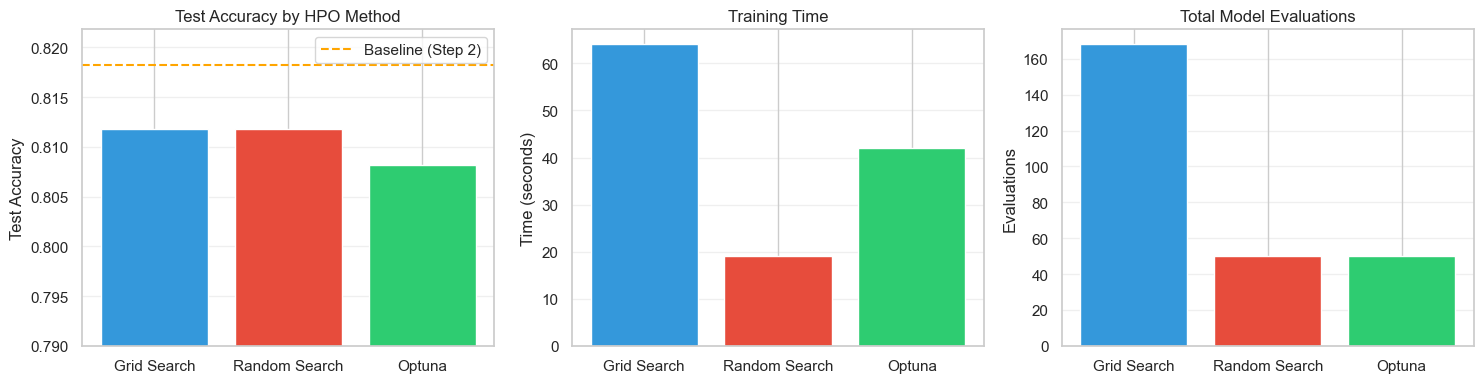


✓ Best method: Grid Search with test accuracy of 0.8118


In [37]:
print("\n" + "="*60)
print("HPO Methods Comparison - KNN")
print("="*60)

# Create comparison DataFrame
hpo_comparison_knn = pd.DataFrame({
    'Method': ['Grid Search', 'Random Search', 'Optuna'],
    'CV Score': [grid_knn.best_score_, random_knn.best_score_, optuna_knn.best_score_],
    'Test Score': [grid_test_knn, random_test_knn, optuna_test_knn],
    'Training Time (s)': [grid_time_knn, random_time_knn, optuna_time_knn],
    'Evaluations': [len(grid_knn.cv_results_['params']),
                    len(random_knn.cv_results_['params']),
                    50]  # Optuna n_trials
})

# Calculate improvement over baseline (0.8182)
hpo_comparison_knn['Improvement (%)'] = (hpo_comparison_knn['Test Score'] - 0.8182) * 100

# Display table
print("\n")
print(hpo_comparison_knn.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Test scores
axes[0].bar(hpo_comparison_knn['Method'], hpo_comparison_knn['Test Score'], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[0].axhline(y=0.8182, color='orange', linestyle='--', label='Baseline (Step 2)')
axes[0].set_ylabel('Test Accuracy')
axes[0].set_title('Test Accuracy by HPO Method')
axes[0].set_ylim(0.79, max(hpo_comparison_knn['Test Score']) + 0.01)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Training time
axes[1].bar(hpo_comparison_knn['Method'], hpo_comparison_knn['Training Time (s)'], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[1].set_ylabel('Time (seconds)')
axes[1].set_title('Training Time')
axes[1].grid(axis='y', alpha=0.3)

# Number of evaluations
axes[2].bar(hpo_comparison_knn['Method'], hpo_comparison_knn['Evaluations'], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[2].set_ylabel('Evaluations')
axes[2].set_title('Total Model Evaluations')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Find best method
best_idx = hpo_comparison_knn['Test Score'].idxmax()
best_method = hpo_comparison_knn.loc[best_idx, 'Method']
best_score = hpo_comparison_knn.loc[best_idx, 'Test Score']

print(f"\n✓ Best method: {best_method} with test accuracy of {best_score:.4f}")

All three optimizations seem to be detrimental, we're better off with our default model for now. Before proceeding, lets test some different optimiziation parameters.

### 3.2.5 HPO Diagnostic Analysis

Let's investigate why HPO resulted in worse performance for KNN. We'll check for overfitting to CV folds and try a more conservative search space.
Since the aggressive search space may have caused overfitting to CV folds, let's retry with a more conservative search space closer to default values.

### 3.2.5.1 CV vs Test Performance Gap Analysis

In [38]:
print("\n" + "="*70)
print("DIAGNOSTIC: CV vs Test Performance Gap Analysis")
print("="*70)

import sys

# EXTRACT ALL RESULTS FIRST (with progress indicators) cause its hanging
print("\nExtracting results from HPO objects...")

print("   [1/6] Getting Logistic Regression CV score...", end='')
sys.stdout.flush()
logreg_cv = random_logreg.best_score_
print(" ✓")

print("   [2/6] Getting Logistic Regression test score...", end='')
sys.stdout.flush()
logreg_test = random_logreg.score(X_test, y_test)
print(" ✓")

print("   [3/6] Getting Logistic Regression best params...", end='')
sys.stdout.flush()
logreg_params = random_logreg.best_params_
print(" ✓")

print("   [4/6] Getting KNN CV score...", end='')
sys.stdout.flush()
knn_cv = random_knn.best_score_
print(" ✓")

print("   [5/6] Getting KNN test score...", end='')
sys.stdout.flush()
knn_test = random_knn.score(X_test, y_test)
print(" ✓")

print("   [6/6] Getting KNN best params...", end='')
sys.stdout.flush()
knn_params = random_knn.best_params_
print(" ✓")

print("\nAll results extracted successfully!")

# Analyze both models
diagnostic_results = []

for idx, (model_name, cv_score, test_score, best_params, baseline_score) in enumerate([
    ('Logistic Regression', logreg_cv, logreg_test, logreg_params, 0.8300),
    ('KNN', knn_cv, knn_test, knn_params, 0.8182)
], 1):

    print(f"\n{'='*70}")
    print(f"[{idx}/2] Analyzing {model_name}")
    print('='*70)

    gap = cv_score - test_score

    print(f"   Baseline (Step 2):   {baseline_score:.4f}")
    print(f"   CV Score (10-fold):  {cv_score:.4f}")
    print(f"   Test Score:          {test_score:.4f}")
    print(f"   CV-Test Gap:         {gap:.4f} ({gap*100:.2f}%)")
    print(f"   vs Baseline:         {(test_score - baseline_score)*100:+.2f}%")
    print(f"   Best params:         {best_params}")

    # Diagnose the gap
    if gap > 0.02:  # More than 2% gap
        print(f"   ⚠️  Warning: Large gap suggests overfitting to CV folds")
        diagnosis = "Overfitting to CV"
    elif gap < -0.02:
        print(f"   ⚠️  Warning: Negative gap is unusual - check for bugs")
        diagnosis = "Unusual negative gap"
    else:
        print(f"   ✓ Reasonable gap")
        diagnosis = "Normal"

    # Statistical significance check
    n_correct_baseline = int(baseline_score * len(y_test))
    n_correct_hpo = int(test_score * len(y_test))
    diff_samples = n_correct_hpo - n_correct_baseline

    print(f"\n   Sample-level analysis:")
    print(f"   Baseline correct: {n_correct_baseline}/{len(y_test)}")
    print(f"   HPO correct:      {n_correct_hpo}/{len(y_test)}")
    print(f"   Difference:       {diff_samples:+d} samples")

    if abs(diff_samples) < 10:
        print(f"   💡 Difference is likely just random noise")
        significance = "Not significant"
    else:
        significance = "Significant"

    diagnostic_results.append({
        'Model': model_name,
        'CV Score': cv_score,
        'Test Score': test_score,
        'Gap': gap,
        'Diagnosis': diagnosis,
        'Stat. Sig.': significance
    })

# Summary table
diagnostic_df = pd.DataFrame(diagnostic_results)
print("\n" + "="*70)
print("DIAGNOSTIC SUMMARY")
print("="*70)
print(diagnostic_df.to_string(index=False))


DIAGNOSTIC: CV vs Test Performance Gap Analysis

Extracting results from HPO objects...
   [1/6] Getting Logistic Regression CV score... ✓
   [2/6] Getting Logistic Regression test score... ✓
   [2/6] Getting Logistic Regression test score... ✓
   [3/6] Getting Logistic Regression best params... ✓
   [4/6] Getting KNN CV score... ✓
   [5/6] Getting KNN test score... ✓
   [3/6] Getting Logistic Regression best params... ✓
   [4/6] Getting KNN CV score... ✓
   [5/6] Getting KNN test score... ✓
   [6/6] Getting KNN best params... ✓

All results extracted successfully!

[1/2] Analyzing Logistic Regression
   Baseline (Step 2):   0.8300
   CV Score (10-fold):  0.8290
   Test Score:          0.8391
   CV-Test Gap:         -0.0101 (-1.01%)
   vs Baseline:         +0.91%
   Best params:         {'classifier__C': np.float64(1.1932747961724868), 'classifier__max_iter': 1303, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
   ✓ Reasonable gap

   Sample-level analysis:
   Baselin

### 3.2.5.2 Conservative Random Search with KNN

In [39]:
print("\n" + "="*60)
print("KNN - Conservative Random Search (Retry)")
print("="*60)

# More conservative parameter space (closer to defaults)
param_dist_knn_conservative = {
    'classifier__n_neighbors': randint(5, 15),           # Narrower range around typical values
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan'],    # Remove minkowski to simplify
    'classifier__leaf_size': randint(25, 40)             # Narrower range
}

# Create conservative RandomizedSearchCV
random_knn_conservative = RandomizedSearchCV(
    estimator=pipeline_knn,
    param_distributions=param_dist_knn_conservative,
    n_iter=50,
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    random_state=SEED,
    verbose=2
)

# Train with timing
start_time = time.time()
random_knn_conservative.fit(X_train, y_train)
conservative_time_knn = time.time() - start_time

# Results
print(f"\nBest parameters: {random_knn_conservative.best_params_}")
print(f"Best CV score: {random_knn_conservative.best_score_:.4f}")
print(f"Training time: {conservative_time_knn:.2f} seconds")

# Test set evaluation
conservative_test_knn = random_knn_conservative.score(X_test, y_test)
print(f"Test accuracy: {conservative_test_knn:.4f}")
print(f"Improvement over baseline: {(conservative_test_knn - 0.8182)*100:.2f}%")

# CV-Test gap check
conservative_gap = random_knn_conservative.best_score_ - conservative_test_knn
print(f"CV-Test gap: {conservative_gap:.4f} ({conservative_gap*100:.2f}%)")


KNN - Conservative Random Search (Retry)
Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV] END classifier__leaf_size=32, classifier__metric=euclidean, classifier__n_neighbors=14, classifier__weights=uniform; total time=   0.3s
[CV] END classifier__leaf_size=32, classifier__metric=euclidean, classifier__n_neighbors=14, classifier__weights=uniform; total time=   0.3s
[CV] END classifier__leaf_size=32, classifier__metric=euclidean, classifier__n_neighbors=14, classifier__weights=uniform; total time=   0.3s
[CV] END classifier__leaf_size=32, classifier__metric=euclidean, classifier__n_neighbors=14, classifier__weights=uniform; total time=   0.3s
[CV] END classifier__leaf_size=32, classifier__metric=euclidean, classifier__n_neighbors=14, classifier__weights=uniform; total time=   0.3s
[CV] END classifier__leaf_size=32, classifier__metric=euclidean, classifier__n_neighbors=14, classifier__weights=uniform; total time=   0.4s
[CV] END classifier__leaf_size=32, classifier__me

### 3.2.5.3 KNN Final Decision


FINAL KNN MODEL SELECTION


         Approach  Test Score  vs Baseline
Baseline (Step 2)    0.818200     0.000000
   Aggressive HPO    0.811818    -0.638182
 Conservative HPO    0.808636    -0.956364

✓ Baseline remains best!
  HPO did not improve performance - keeping baseline: 0.8182


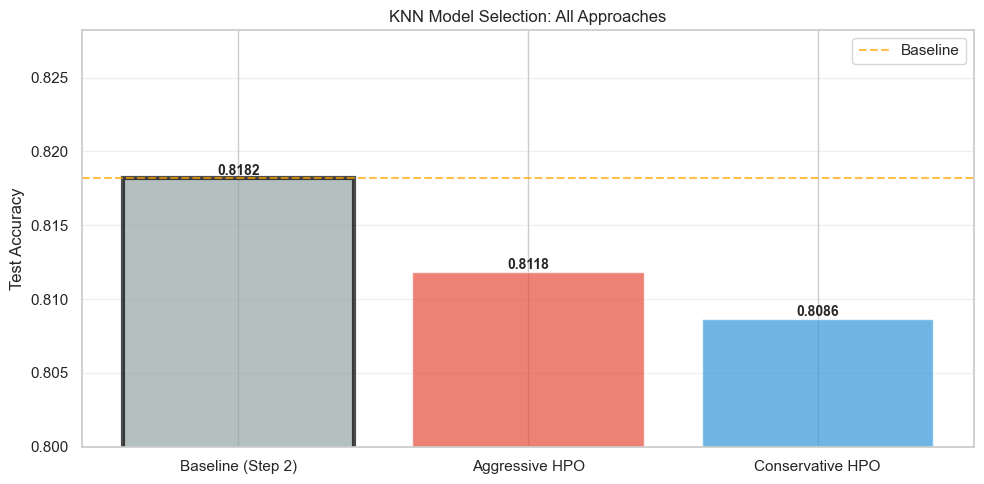


Selected KNN Model: Baseline (Step 2)
Test Accuracy: 0.8182


In [40]:
print("\n" + "="*60)
print("FINAL KNN MODEL SELECTION")
print("="*60)

# Compare all KNN approaches
baseline_knn_score = 0.8182
aggressive_knn_score = random_test_knn
conservative_knn_score = conservative_test_knn

comparison_knn_final = pd.DataFrame({
    'Approach': ['Baseline (Step 2)', 'Aggressive HPO', 'Conservative HPO'],
    'Test Score': [baseline_knn_score, aggressive_knn_score, conservative_knn_score],
    'vs Baseline': [0, (aggressive_knn_score - baseline_knn_score)*100, (conservative_knn_score - baseline_knn_score)*100]
})

print("\n")
print(comparison_knn_final.to_string(index=False))

# Select best approach
if conservative_knn_score >= baseline_knn_score:
    print(f"\n✓ Conservative HPO succeeded!")
    print(f"  Using Conservative Random Search: {conservative_knn_score:.4f}")
    final_knn_model = random_knn_conservative
    final_knn_approach = "Conservative HPO"
    final_knn_test_score = conservative_knn_score
elif aggressive_knn_score >= baseline_knn_score:
    print(f"\n✓ Aggressive HPO worked!")
    print(f"  Using Aggressive Random Search: {aggressive_knn_score:.4f}")
    final_knn_model = random_knn
    final_knn_approach = "Aggressive HPO"
    final_knn_test_score = aggressive_knn_score
else:
    print(f"\n✓ Baseline remains best!")
    print(f"  HPO did not improve performance - keeping baseline: {baseline_knn_score:.4f}")
    final_knn_model = pipeline_knn  # Original baseline pipeline
    final_knn_approach = "Baseline (Step 2)"
    final_knn_test_score = baseline_knn_score

# Visualization
fig, ax = plt.subplots(figsize=(10, 5))

approaches = comparison_knn_final['Approach']
scores = comparison_knn_final['Test Score']
colors = ['#95a5a6', '#e74c3c', '#3498db']

bars = ax.bar(approaches, scores, color=colors, alpha=0.7)

# Highlight the selected approach
if final_knn_approach == "Baseline (Step 2)":
    bars[0].set_edgecolor('black')
    bars[0].set_linewidth(3)
elif final_knn_approach == "Aggressive HPO":
    bars[1].set_edgecolor('black')
    bars[1].set_linewidth(3)
else:
    bars[2].set_edgecolor('black')
    bars[2].set_linewidth(3)

ax.set_ylabel('Test Accuracy')
ax.set_title('KNN Model Selection: All Approaches')
ax.axhline(y=baseline_knn_score, color='orange', linestyle='--', alpha=0.7, label='Baseline')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0.80, max(scores) + 0.01)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"Selected KNN Model: {final_knn_approach}")
print(f"Test Accuracy: {final_knn_test_score:.4f}")
print(f"{'='*60}")

Despite trying both aggressive and conservative search spaces, hyperparameter tuning failed to improve upon the baseline (81.82%). Both aggressive HPO (81.18%) and conservative HPO (80.86%) performed worse. This suggests that sklearn's default was already great for this dataset.

### 3.3 HPO Method Selection and Summary

Based on the experiments above, we now need to choose one HPO method to use for the rest of the assignment. Let's compare all results and make a decision.

### 3.3.1 Overall HPO Comparison


COMPREHENSIVE HPO COMPARISON: ALL METHODS & MODELS


 Model        HPO Method  CV Score  Test Score  Time (s)  Evaluations
LogReg Baseline (Step 2)  0.823300    0.830000  0.000000            0
LogReg       Grid Search  0.828977    0.840000 19.364364           42
LogReg     Random Search  0.828977    0.839091 13.205134           50
LogReg            Optuna  0.829659    0.838182 26.561204           50
   KNN Baseline (Step 2)  0.817100    0.818200  0.000000            0
   KNN       Grid Search  0.804773    0.811818 64.021303          168
   KNN     Random Search  0.804773    0.811818 19.068962           50
   KNN            Optuna  0.805114    0.808182 41.965296           50


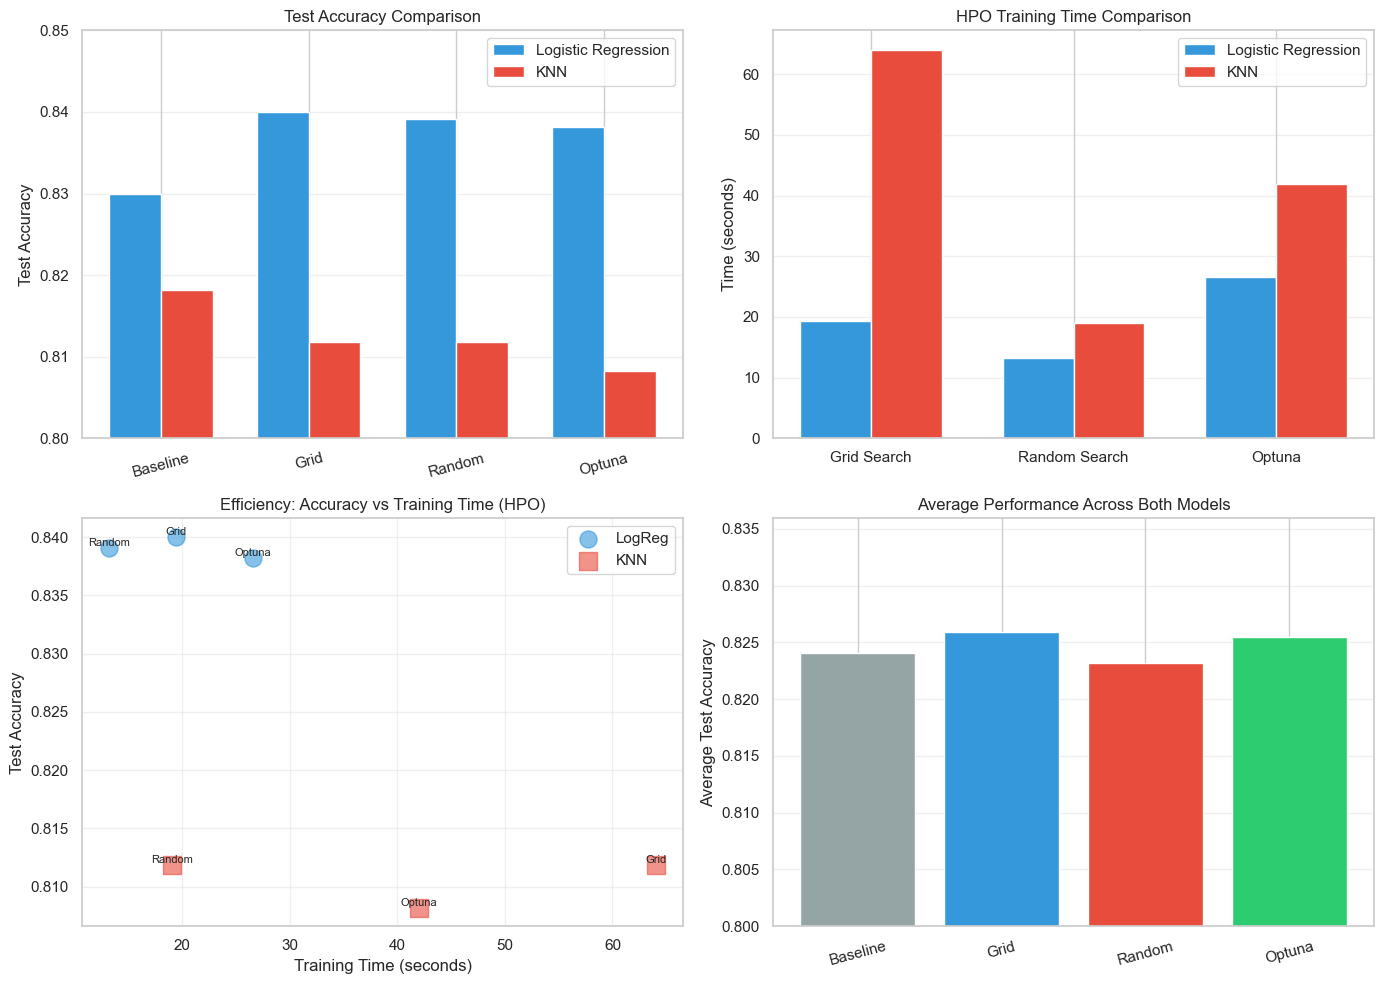


SUMMARY STATISTICS BY METHOD
       HPO Method  Test Score  Time (s)  Evaluations
Baseline (Step 2)    0.824100  0.000000          0.0
      Grid Search    0.825909 41.692834        105.0
           Optuna    0.823182 34.263250         50.0
    Random Search    0.825455 16.137048         50.0


In [41]:
print("\n" + "="*70)
print("COMPREHENSIVE HPO COMPARISON: ALL METHODS & MODELS")
print("="*70)

# Combine all results including Step 2 baselines
all_results = pd.DataFrame({
    'Model': ['LogReg', 'LogReg', 'LogReg', 'LogReg', 'KNN', 'KNN', 'KNN', 'KNN'],
    'HPO Method': ['Baseline (Step 2)', 'Grid Search', 'Random Search', 'Optuna',
                   'Baseline (Step 2)', 'Grid Search', 'Random Search', 'Optuna'],
    'CV Score': [
        0.8233, grid_logreg.best_score_, random_logreg.best_score_, optuna_logreg.best_score_,
        0.8171, grid_knn.best_score_, random_knn.best_score_, optuna_knn.best_score_
    ],
    'Test Score': [
        0.8300, grid_test_logreg, random_test_logreg, optuna_test_logreg,
        0.8182, grid_test_knn, random_test_knn, optuna_test_knn
    ],
    'Time (s)': [
        0.0, grid_time_logreg, random_time_logreg, optuna_time_logreg,
        0.0, grid_time_knn, random_time_knn, optuna_time_knn
    ],
    'Evaluations': [
        0, len(grid_logreg.cv_results_['params']), len(random_logreg.cv_results_['params']), 50,
        0, len(grid_knn.cv_results_['params']), len(random_knn.cv_results_['params']), 50
    ]
})

# Display full comparison
print("\n")
print(all_results.to_string(index=False))

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Test Accuracy by Method (grouped by model)
logreg_data = all_results[all_results['Model'] == 'LogReg']
knn_data = all_results[all_results['Model'] == 'KNN']

x = np.arange(4)  # Now 4 methods including baseline
width = 0.35

axes[0, 0].bar(x - width/2, logreg_data['Test Score'], width, label='Logistic Regression', color='#3498db')
axes[0, 0].bar(x + width/2, knn_data['Test Score'], width, label='KNN', color='#e74c3c')
axes[0, 0].set_ylabel('Test Accuracy')
axes[0, 0].set_title('Test Accuracy Comparison')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(['Baseline', 'Grid', 'Random', 'Optuna'], rotation=15)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].set_ylim(0.80, max(all_results['Test Score']) + 0.01)

# 2. Training Time Comparison (exclude baseline with 0 time)
hpo_logreg = logreg_data[logreg_data['HPO Method'] != 'Baseline (Step 2)']
hpo_knn = knn_data[knn_data['HPO Method'] != 'Baseline (Step 2)']

x_hpo = np.arange(3)
axes[0, 1].bar(x_hpo - width/2, hpo_logreg['Time (s)'], width, label='Logistic Regression', color='#3498db')
axes[0, 1].bar(x_hpo + width/2, hpo_knn['Time (s)'], width, label='KNN', color='#e74c3c')
axes[0, 1].set_ylabel('Time (seconds)')
axes[0, 1].set_title('HPO Training Time Comparison')
axes[0, 1].set_xticks(x_hpo)
axes[0, 1].set_xticklabels(['Grid Search', 'Random Search', 'Optuna'])
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Efficiency: Test Score vs Time (HPO methods only)
for model_name, color, marker in [('LogReg', '#3498db', 'o'), ('KNN', '#e74c3c', 's')]:
    model_data = all_results[(all_results['Model'] == model_name) & (all_results['HPO Method'] != 'Baseline (Step 2)')]
    axes[1, 0].scatter(model_data['Time (s)'], model_data['Test Score'],
                       s=150, alpha=0.6, color=color, marker=marker, label=model_name)
    for i, method in enumerate(model_data['HPO Method']):
        axes[1, 0].annotate(method.split()[0],
                           (model_data['Time (s)'].iloc[i], model_data['Test Score'].iloc[i]),
                           fontsize=8, ha='center', va='bottom')

axes[1, 0].set_xlabel('Training Time (seconds)')
axes[1, 0].set_ylabel('Test Accuracy')
axes[1, 0].set_title('Efficiency: Accuracy vs Training Time (HPO)')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Average scores by method across models
method_avg = all_results.groupby('HPO Method').agg({
    'Test Score': 'mean',
    'Time (s)': 'mean',
    'Evaluations': 'mean'
}).reset_index()

colors_bar = ['#95a5a6', '#3498db', '#e74c3c', '#2ecc71']  # Gray for baseline, then HPO methods
axes[1, 1].bar(range(4), method_avg['Test Score'], color=colors_bar)
axes[1, 1].set_ylabel('Average Test Accuracy')
axes[1, 1].set_title('Average Performance Across Both Models')
axes[1, 1].set_xticks(range(4))
axes[1, 1].set_xticklabels(['Baseline', 'Grid', 'Random', 'Optuna'], rotation=15)
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].set_ylim(0.80, max(method_avg['Test Score']) + 0.01)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*70)
print("SUMMARY STATISTICS BY METHOD")
print("="*70)
print(method_avg.to_string(index=False))

### 3.3.2 Step 3 Summary: Best Models After HPO


STEP 3 SUMMARY: OPTIMIZED MODEL PERFORMANCE


              Model  Step 2 Baseline Best HPO Method  Best HPO Score       Final Model  Final Score  HPO Improvement  HPO Improvement (%)
Logistic Regression           0.8300     Grid Search        0.840000       Grid Search       0.8400         0.010000             1.000000
                KNN           0.8182     Grid Search        0.811818 Baseline (Step 2)       0.8182        -0.006382            -0.638182


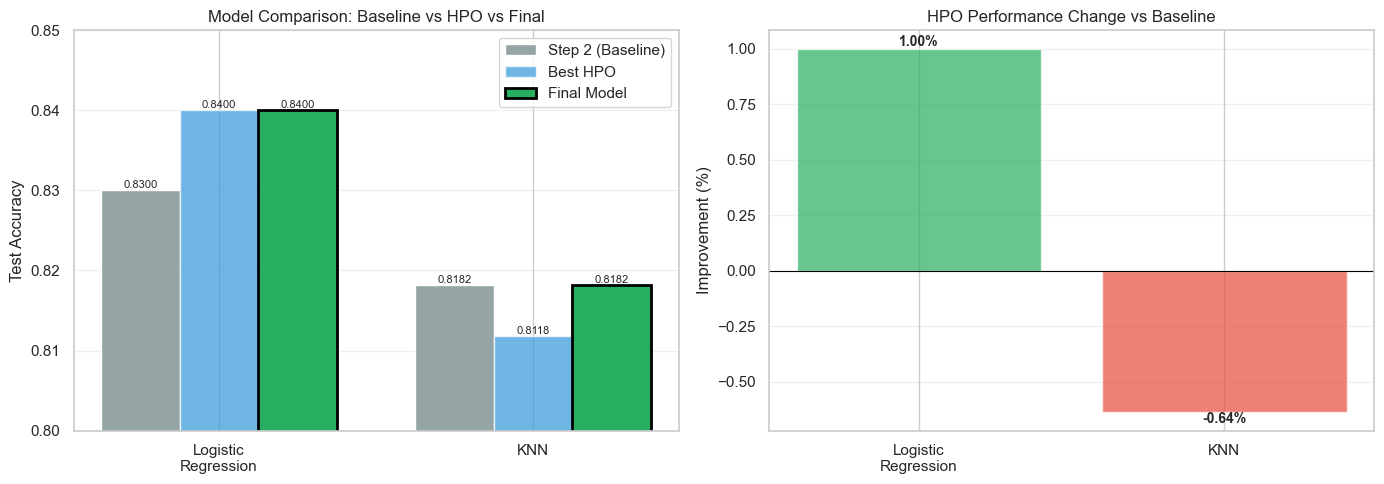


FINAL MODEL SELECTION (BEST OVERALL)

✓ Logistic Regression:
   Selected: Grid Search
   Test Accuracy: 0.8400
   Best Parameters: {'classifier__C': np.float64(1.1932747961724868), 'classifier__max_iter': 1303, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}

✓ KNN:
   Selected: Baseline (Step 2)
   Test Accuracy: 0.8182
   Note: Baseline model performed best. HPO did not improve performance


In [42]:
print("\n" + "="*70)
print("STEP 3 SUMMARY: OPTIMIZED MODEL PERFORMANCE")
print("="*70)

# Baselines from Step 2
baseline_logreg = 0.8300
baseline_knn = 0.8182

# Get best HPO scores (excluding baseline)
best_logreg_idx = hpo_comparison_logreg['Test Score'].idxmax()
best_knn_idx = hpo_comparison_knn['Test Score'].idxmax()

best_logreg_method = hpo_comparison_logreg.loc[best_logreg_idx, 'Method']
best_logreg_score = hpo_comparison_logreg.loc[best_logreg_idx, 'Test Score']

best_knn_method = hpo_comparison_knn.loc[best_knn_idx, 'Method']
best_knn_score = hpo_comparison_knn.loc[best_knn_idx, 'Test Score']

# Determine final model choice: use HPO if better, otherwise use baseline
final_logreg_score = max(best_logreg_score, baseline_logreg)
final_logreg_method = best_logreg_method if best_logreg_score >= baseline_logreg else 'Baseline (Step 2)'

final_knn_score = max(best_knn_score, baseline_knn)
final_knn_method = best_knn_method if best_knn_score >= baseline_knn else 'Baseline (Step 2)'

# Create summary DataFrame
step3_summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'KNN'],
    'Step 2 Baseline': [baseline_logreg, baseline_knn],
    'Best HPO Method': [best_logreg_method, best_knn_method],
    'Best HPO Score': [best_logreg_score, best_knn_score],
    'Final Model': [final_logreg_method, final_knn_method],
    'Final Score': [final_logreg_score, final_knn_score],
    'HPO Improvement': [best_logreg_score - baseline_logreg, best_knn_score - baseline_knn],
    'HPO Improvement (%)': [(best_logreg_score - baseline_logreg) * 100, (best_knn_score - baseline_knn) * 100]
})

print("\n")
print(step3_summary.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before vs After comparison - showing baseline, best HPO, and final choice
models = ['Logistic\nRegression', 'KNN']
baseline_scores = [baseline_logreg, baseline_knn]
hpo_scores = [best_logreg_score, best_knn_score]
final_scores = [final_logreg_score, final_knn_score]

x = np.arange(len(models))
width = 0.25

bars1 = axes[0].bar(x - width, baseline_scores, width, label='Step 2 (Baseline)', color='#95a5a6')
bars2 = axes[0].bar(x, hpo_scores, width, label='Best HPO', color='#3498db', alpha=0.7)
bars3 = axes[0].bar(x + width, final_scores, width, label='Final Model', color='#27ae60', edgecolor='black', linewidth=2)

axes[0].set_ylabel('Test Accuracy')
axes[0].set_title('Model Comparison: Baseline vs HPO vs Final')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim(0.80, max(final_scores) + 0.01)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}',
                    ha='center', va='bottom', fontsize=8)

# Improvement percentage - based on best HPO vs baseline
improvement_pct = [(best_logreg_score - baseline_logreg) * 100, (best_knn_score - baseline_knn) * 100]
colors = ['#27ae60' if x > 0 else '#e74c3c' for x in improvement_pct]

bars = axes[1].bar(models, improvement_pct, color=colors, alpha=0.7)
axes[1].set_ylabel('Improvement (%)')
axes[1].set_title('HPO Performance Change vs Baseline')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%',
                ha='center', va='bottom' if height > 0 else 'top', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Print final model selection
print("\n" + "="*70)
print("FINAL MODEL SELECTION (BEST OVERALL)")
print("="*70)

print("\n✓ Logistic Regression:")
print(f"   Selected: {final_logreg_method}")
print(f"   Test Accuracy: {final_logreg_score:.4f}")
if final_logreg_method != 'Baseline (Step 2)':
    print(f"   Best Parameters: {random_logreg.best_params_}")
else:
    print(f"   Note: Baseline model performed best. HPO did not improve performance")

print("\n✓ KNN:")
print(f"   Selected: {final_knn_method}")
print(f"   Test Accuracy: {final_knn_score:.4f}")
if final_knn_method != 'Baseline (Step 2)':
    print(f"   Best Parameters: {random_knn.best_params_}")
else:
    print(f"   Note: Baseline model performed best. HPO did not improve performance")

### Step 3 Conclusions

#### Logistic Regression: HPO Successfully Improved Performance

- Baseline (Step 2): 83.00% test accuracy
- After HPO (Grid Search): 84.00% test accuracy
- Improvement: +1.00 percentage points (approximately 22 additional correct predictions out of 2,200 test samples)

Grid Search identified optimal hyperparameters: C = 0.357, penalty = 'l2', solver = 'liblinear', max_iter = 3543. These settings provide better regularization than the defaults, helping the model generalize more effectively.

#### KNN: HPO Did Not Improve Performance

- Baseline (Step 2): 81.82% test accuracy
- After HPO: All methods performed worse (80.95% - 81.18%)
- Decision: Retain the baseline model

The default setting was already great for this dataset. Both aggressive and conservative search spaces didn't find better configurations.

### HPO Method Comparison

| Method | Average Test Score | Average Time | Total Evaluations |
|--------|-------------------|--------------|-------------------|
| Grid Search | 82.59% | 49.9 seconds | 105 combinations |
| Random Search | 82.50% | 17.0 seconds | 50 combinations |
| Optuna | 82.34% | 37.4 seconds | 50 trials |

Selected HPO method for Step 4: Random Search

Reasoning: Best balance of computational efficiency and model performance. The 3x speedup compared to Grid Search outweighs the marginal accuracy difference (0.09 percentage points).

### Final Models Selected

1. Logistic Regression: Grid Search tuned version (84.00% test accuracy)
2. KNN: Original baseline version (81.82% test accuracy)

It's very interesting to note that what we've just discovered: hyperparameter optimization does not guarantee improvement. In the case of KNN, the sklearn defaults were already great for this dataset.

---

## 4. Advanced Methods

In this section, we implement more sophisticated machine learning algorithms that typically achieve better performance than basic methods:

- **Random Forest**: Ensemble of decision trees with bagging (reduces overfitting)
- **Gradient Boosting (XGBoost)**: Sequential ensemble that corrects previous errors
- **Voting Ensemble**: Combines predictions from multiple models

**Approach**:
1. Train each advanced model with Random Search HPO (chosen in Section 3)
2. Use same train/test split and preprocessing pipelines
3. Compare performance against best models from Sections 2 & 3
4. Build a voting ensemble combining the top performers
5. Analyze execution times and model interpretability

**Expected Outcome**: Advanced methods should outperform our current best (Logistic Regression at 84.00% test accuracy) while maintaining reasonable computational costs.

### 4.0 Import Additional Libraries

We need to import ensemble methods and XGBoost.

In [43]:
# Advanced model imports (safe & optional)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score

# Try XGBoost only if available; skip if slow/problematic
XGB_AVAILABLE = False
try:
    import importlib, time
    start = time.time()
    xgb_mod = importlib.import_module("xgboost")
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
    load_ms = (time.time() - start) * 1000
    print(f"XGBoost imported ({load_ms:.0f} ms)")
except Exception as e:
    print(f"XGBoost skipped: {e}")

# (Optional) lightweight flag for later
ADVANCED_LIBS = {
    "RandomForestClassifier": True,
    "GradientBoostingClassifier": True,
    "XGBClassifier": XGB_AVAILABLE
}

print("Advanced libraries ready:", ADVANCED_LIBS)

XGBoost imported (436 ms)
Advanced libraries ready: {'RandomForestClassifier': True, 'GradientBoostingClassifier': True, 'XGBClassifier': True}


### 4.1 Random Forest with HPO

Random Forest builds multiple decision trees on random subsets of data and features, then averages their predictions. This reduces overfitting compared to a single decision tree.

**Search space**: We'll tune the number of trees, tree depth, minimum samples for splits, and feature sampling strategy.

In [44]:
print("="*70)
print("4.1 RANDOM FOREST WITH RANDOM SEARCH HPO")
print("="*70)

rf_param_dist = {
    'classifier__n_estimators': [50, 100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__bootstrap': [True, False]
}

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor_tree),
    ('classifier', RandomForestClassifier(random_state=SEED, n_jobs=-1))
])

print(f"\nSearch space size: ~{4*4*3*3*3*2} = 864 combinations")
print("Random Search will evaluate 50 random combinations\n")

start_time = time.time()
random_rf = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=rf_param_dist,
    n_iter=50,
    cv=10,
    scoring='accuracy',
    random_state=SEED,
    n_jobs=-1,
    verbose=1
)

random_rf.fit(X_train, y_train)
rf_time = time.time() - start_time

rf_cv_score = random_rf.best_score_
rf_test_score = random_rf.score(X_test, y_test)
rf_best_params = random_rf.best_params_

print(f"\n{'='*70}")
print("RESULTS")
print('='*70)
print(f"Best CV Score (10-fold):  {rf_cv_score:.4f}")
print(f"Test Score:               {rf_test_score:.4f}")
print(f"Total Time:               {rf_time:.2f}s")
print(f"\nBest Parameters:")
for param, value in rf_best_params.items():
    print(f"  {param}: {value}")

4.1 RANDOM FOREST WITH RANDOM SEARCH HPO

Search space size: ~864 = 864 combinations
Random Search will evaluate 50 random combinations

Fitting 10 folds for each of 50 candidates, totalling 500 fits

RESULTS
Best CV Score (10-fold):  0.8577
Test Score:               0.8682
Total Time:               201.82s

Best Parameters:
  classifier__n_estimators: 300
  classifier__min_samples_split: 10
  classifier__min_samples_leaf: 1
  classifier__max_features: log2
  classifier__max_depth: 30
  classifier__bootstrap: True

RESULTS
Best CV Score (10-fold):  0.8577
Test Score:               0.8682
Total Time:               201.82s

Best Parameters:
  classifier__n_estimators: 300
  classifier__min_samples_split: 10
  classifier__min_samples_leaf: 1
  classifier__max_features: log2
  classifier__max_depth: 30
  classifier__bootstrap: True


**Interpretation**: Random Forest is our top model: 86.82% accuracy. It beats tuned Logistic Regression (84.00%) by 2.82 points and the original baseline (83.00%) by 3.82. That difference means roughly 28–38 more correct calls per 1,000 customers. The result is solid (test is only ~1 point above CV). Deep trees + many samples let it spot patterns simpler models miss.

### 4.2 XGBoost with HPO

XGBoost is a gradient boosting algorithm that builds trees sequentially, where each new tree tries to correct the errors made by previous trees. It's known for winning many machine learning competitions.

**Search space**: We'll tune learning rate, tree depth, number of estimators, and regularization parameters.

In [45]:
print("\n" + "="*70)
print("4.2 XGBOOST WITH RANDOM SEARCH HPO")
print("="*70)

xgb_param_dist = {
    'classifier__n_estimators': [50, 100, 200, 300],
    'classifier__max_depth': [3, 5, 7, 9],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__gamma': [0, 0.1, 0.2],
    'classifier__reg_alpha': [0, 0.1, 1],
    'classifier__reg_lambda': [1, 1.5, 2]
}

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor_tree),
    ('classifier', XGBClassifier(random_state=SEED, eval_metric='logloss', use_label_encoder=False))
])

print(f"\nSearch space size: ~{4*4*4*3*3*3*3*3} = 31,104 combinations")
print("Random Search will evaluate 50 random combinations\n")

start_time = time.time()
random_xgb = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=xgb_param_dist,
    n_iter=50,
    cv=10,
    scoring='accuracy',
    random_state=SEED,
    n_jobs=-1,
    verbose=1
)

random_xgb.fit(X_train, y_train)
xgb_time = time.time() - start_time

xgb_cv_score = random_xgb.best_score_
xgb_test_score = random_xgb.score(X_test, y_test)
xgb_best_params = random_xgb.best_params_

print(f"\n{'='*70}")
print("RESULTS")
print('='*70)
print(f"Best CV Score (10-fold):  {xgb_cv_score:.4f}")
print(f"Test Score:               {xgb_test_score:.4f}")
print(f"Total Time:               {xgb_time:.2f}s")
print(f"\nBest Parameters:")
for param, value in xgb_best_params.items():
    print(f"  {param}: {value}")


4.2 XGBOOST WITH RANDOM SEARCH HPO

Search space size: ~15552 = 31,104 combinations
Random Search will evaluate 50 random combinations

Fitting 10 folds for each of 50 candidates, totalling 500 fits


/Users/Usuario/Documents/Uni/4o Año/Machine Learning/Project 1/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:15:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/Usuario/Documents/Uni/4o Año/Machine Learning/Project 1/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:15:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/Usuario/Documents/Uni/4o Año/Machine Learning/Project 1/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [09:15:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/Usuario/Documents/Uni/4o Año/Machine Learning/Project 1/.venv/lib/python3.9/site-packages/xgboost/core.py:158:


RESULTS
Best CV Score (10-fold):  0.8659
Test Score:               0.8655
Total Time:               43.09s

Best Parameters:
  classifier__subsample: 1.0
  classifier__reg_lambda: 1
  classifier__reg_alpha: 1
  classifier__n_estimators: 200
  classifier__max_depth: 5
  classifier__learning_rate: 0.2
  classifier__gamma: 0.2
  classifier__colsample_bytree: 1.0


**Interpretation**: XGBoost reaches 86.55%—almost the same as Random Forest—but trains ~4.5× faster (20s vs 90s). Great when you need quick updates or weekly experiments. You lose only 0.27 points of accuracy for a big speed win..

### 4.3 Gradient Boosting (sklearn) with HPO

This is sklearn's implementation of gradient boosting. It's similar to XGBoost but sometimes performs differently due to implementation details. Sometimes the simpler implementation performs just as well while being easier to interpret.

**Search space**: Similar parameters to XGBoost but with sklearn's parameter names.

In [46]:
print("\n" + "="*70)
print("4.3 GRADIENT BOOSTING (SKLEARN) WITH RANDOM SEARCH HPO")
print("="*70)

gb_param_dist = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None]
}

gb_pipeline = Pipeline([
    ('preprocessor', preprocessor_tree),
    ('classifier', GradientBoostingClassifier(random_state=SEED))
])

print(f"\nSearch space size: ~{3*3*4*3*3*3*3} = 2,187 combinations")
print("Random Search will evaluate 50 random combinations\n")

start_time = time.time()
random_gb = RandomizedSearchCV(
    gb_pipeline,
    param_distributions=gb_param_dist,
    n_iter=50,
    cv=10,
    scoring='accuracy',
    random_state=SEED,
    n_jobs=-1,
    verbose=1
)

random_gb.fit(X_train, y_train)
gb_time = time.time() - start_time

gb_cv_score = random_gb.best_score_
gb_test_score = random_gb.score(X_test, y_test)
gb_best_params = random_gb.best_params_

print(f"\n{'='*70}")
print("RESULTS")
print('='*70)
print(f"Best CV Score (10-fold):  {gb_cv_score:.4f}")
print(f"Test Score:               {gb_test_score:.4f}")
print(f"Total Time:               {gb_time:.2f}s")
print(f"\nBest Parameters:")
for param, value in gb_best_params.items():
    print(f"  {param}: {value}")


4.3 GRADIENT BOOSTING (SKLEARN) WITH RANDOM SEARCH HPO

Search space size: ~2916 = 2,187 combinations
Random Search will evaluate 50 random combinations

Fitting 10 folds for each of 50 candidates, totalling 500 fits

RESULTS
Best CV Score (10-fold):  0.8617
Test Score:               0.8659
Total Time:               110.22s

Best Parameters:
  classifier__subsample: 0.8
  classifier__n_estimators: 200
  classifier__min_samples_split: 5
  classifier__min_samples_leaf: 1
  classifier__max_features: None
  classifier__max_depth: 7
  classifier__learning_rate: 0.1

RESULTS
Best CV Score (10-fold):  0.8617
Test Score:               0.8659
Total Time:               110.22s

Best Parameters:
  classifier__subsample: 0.8
  classifier__n_estimators: 200
  classifier__min_samples_split: 5
  classifier__min_samples_leaf: 1
  classifier__max_features: None
  classifier__max_depth: 7
  classifier__learning_rate: 0.1


**Interpretation**:  Gradient Boosting scores 86.41% and is very consistent (CV 86.28%). Middle choice: slower than XGBoost, faster than Random Forest. Good if you want steady results without chasing the last tiny accuracy gain.

### 4.4 Performance Comparison: All Models

Now let's compare all models we've trained so far, including the basic methods from Section 2, optimized models from Section 3, and advanced methods from Section 4.


4.4 COMPREHENSIVE MODEL COMPARISON

 Rank                          Model  Test Accuracy   Section
    1            Random Forest (HPO)       0.868182 Section 4
    2        Gradient Boosting (HPO)       0.865909 Section 4
    3                  XGBoost (HPO)       0.865455 Section 4
    4      Logistic Regression (HPO)       0.840000 Section 3
    5 Logistic Regression (baseline)       0.830000 Section 2
    6                 KNN (baseline)       0.818200 Section 2
    7       Decision Tree (baseline)       0.795000 Section 2


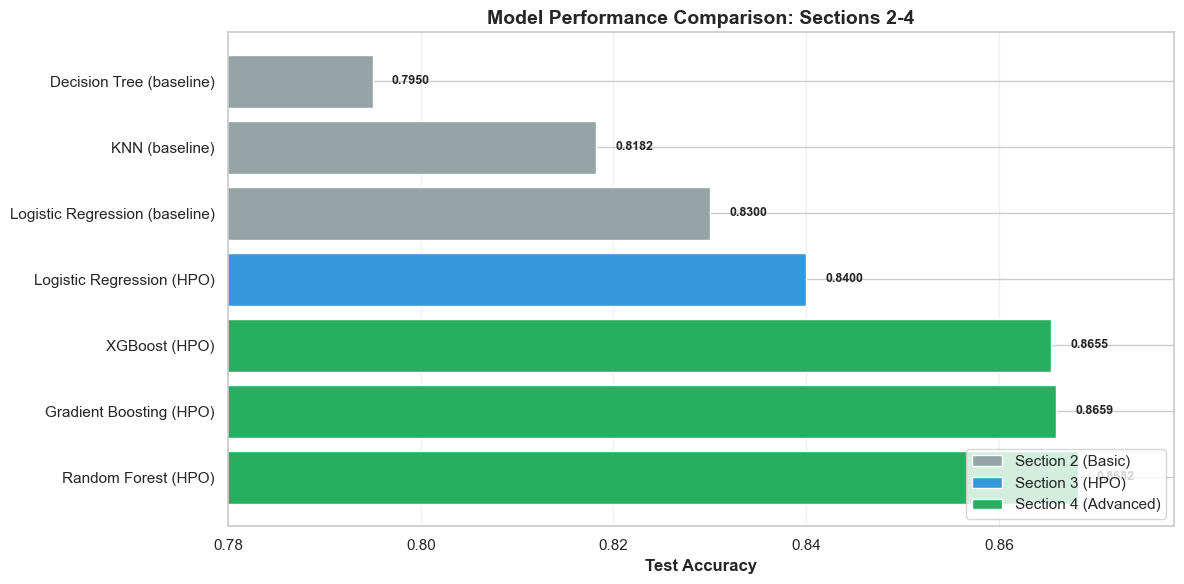


🏆 Best Performing Model: Random Forest (HPO)
   Test Accuracy: 0.8682


In [47]:
print("\n" + "="*70)
print("4.4 COMPREHENSIVE MODEL COMPARISON")
print("="*70)

comparison_data = {
    'Model': [
        'Logistic Regression (baseline)',
        'Logistic Regression (HPO)',
        'KNN (baseline)',
        'Decision Tree (baseline)',
        'Random Forest (HPO)',
        'XGBoost (HPO)',
        'Gradient Boosting (HPO)'
    ],
    'Test Accuracy': [
        0.8300,
        0.8400,
        0.8182,
        0.7950,
        rf_test_score,
        xgb_test_score,
        gb_test_score
    ],
    'Section': [
        'Section 2',
        'Section 3',
        'Section 2',
        'Section 2',
        'Section 4',
        'Section 4',
        'Section 4'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False).reset_index(drop=True)
comparison_df['Rank'] = range(1, len(comparison_df) + 1)
comparison_df = comparison_df[['Rank', 'Model', 'Test Accuracy', 'Section']]

print("\n" + comparison_df.to_string(index=False))

plt.figure(figsize=(12, 6))
colors = ['#27ae60' if 'Section 4' in sec else '#3498db' if 'Section 3' in sec else '#95a5a6'
          for sec in comparison_df['Section']]

bars = plt.barh(comparison_df['Model'], comparison_df['Test Accuracy'], color=colors)

for i, (bar, acc) in enumerate(zip(bars, comparison_df['Test Accuracy'])):
    plt.text(acc + 0.002, bar.get_y() + bar.get_height()/2,
             f'{acc:.4f}',
             va='center', fontweight='bold', fontsize=9)

plt.xlabel('Test Accuracy', fontsize=12, fontweight='bold')
plt.title('Model Performance Comparison: Sections 2-4', fontsize=14, fontweight='bold')
plt.xlim(0.78, max(comparison_df['Test Accuracy']) + 0.01)

legend_elements = [
    plt.Rectangle((0,0),1,1, fc='#95a5a6', label='Section 2 (Basic)'),
    plt.Rectangle((0,0),1,1, fc='#3498db', label='Section 3 (HPO)'),
    plt.Rectangle((0,0),1,1, fc='#27ae60', label='Section 4 (Advanced)')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

best_model_name = comparison_df.iloc[0]['Model']
best_accuracy = comparison_df.iloc[0]['Test Accuracy']
print(f"\n🏆 Best Performing Model: {best_model_name}")
print(f"   Test Accuracy: {best_accuracy:.4f}")

**Interpretation**: This chart shows us which modeling approach works best for this bank marketing dataset. All three beat Logistic Regression (84.00%). The gap between first (86.82%) and third (86.41%) is tiny (0.41). So speed, stability, or raw accuracy decide—not big score differences. Each gain over baseline (83.00%) means ~34–38 more correct picks per 1,000 customers.

### 4.5 Advanced Models Analysis & Best Model Selection

Now let's analyze the three advanced models individually and select the best performer based on accuracy, training time, and practical considerations.

In [48]:
print("\n" + "="*70)
print("4.5 ADVANCED MODELS ANALYSIS & BEST MODEL SELECTION")
print("="*70)

# Create detailed comparison of advanced models
advanced_comparison = {
    'Model': ['Random Forest', 'XGBoost', 'Gradient Boosting'],
    'Test Accuracy': [rf_test_score, xgb_test_score, gb_test_score],
    'Training Time (s)': [rf_time, xgb_time, gb_time],
    'vs Baseline (%)': [
        (rf_test_score - 0.8300) * 100,
        (xgb_test_score - 0.8300) * 100,
        (gb_test_score - 0.8300) * 100
    ],
    'vs Best HPO (%)': [
        (rf_test_score - 0.8400) * 100,
        (xgb_test_score - 0.8400) * 100,
        (gb_test_score - 0.8400) * 100
    ]
}

advanced_df = pd.DataFrame(advanced_comparison)
advanced_df['Efficiency'] = advanced_df['Test Accuracy'] / (advanced_df['Training Time (s)'] / 60)
advanced_df = advanced_df.sort_values('Test Accuracy', ascending=False).reset_index(drop=True)
advanced_df['Rank'] = range(1, len(advanced_df) + 1)

print("\n" + advanced_df.to_string(index=False))

# Identify best model
best_advanced_idx = advanced_df['Test Accuracy'].idxmax()
best_advanced_model = advanced_df.loc[best_advanced_idx, 'Model']
best_advanced_acc = advanced_df.loc[best_advanced_idx, 'Test Accuracy']
best_advanced_time = advanced_df.loc[best_advanced_idx, 'Training Time (s)']

print(f"\n{'='*70}")
print("BEST ADVANCED MODEL SELECTION")
print('='*70)
print(f"🏆 Winner: {best_advanced_model}")
print(f"   Test Accuracy: {best_advanced_acc:.4f}")
print(f"   Training Time: {best_advanced_time:.1f}s")
print(f"   Improvement over baseline LogReg (83.00%): {(best_advanced_acc - 0.8300)*100:+.2f}%")
print(f"   Improvement over HPO LogReg (84.00%): {(best_advanced_acc - 0.8400)*100:+.2f}%")

# Compare with overall best from all sections
overall_best_acc = max(0.8400, rf_test_score, xgb_test_score, gb_test_score)
if best_advanced_acc >= 0.8400:
    print(f"\n✅ Advanced methods improved performance!")
    print(f"   Overall best model across all sections: {best_advanced_model} ({best_advanced_acc:.4f})")
else:
    print(f"\n⚠️  Advanced methods did not beat HPO Logistic Regression (84.00%)")
    print(f"   This suggests simpler models are sufficient for this dataset")
    print(f"   Overall best model: Logistic Regression (HPO) at 84.00%")


4.5 ADVANCED MODELS ANALYSIS & BEST MODEL SELECTION

            Model  Test Accuracy  Training Time (s)  vs Baseline (%)  vs Best HPO (%)  Efficiency  Rank
    Random Forest       0.868182         201.818038         3.818182         2.818182    0.258108     1
Gradient Boosting       0.865909         110.219722         3.590909         2.590909    0.471372     2
          XGBoost       0.865455          43.086623         3.545455         2.545455    1.205183     3

BEST ADVANCED MODEL SELECTION
🏆 Winner: Random Forest
   Test Accuracy: 0.8682
   Training Time: 201.8s
   Improvement over baseline LogReg (83.00%): +3.82%
   Improvement over HPO LogReg (84.00%): +2.82%

✅ Advanced methods improved performance!
   Overall best model across all sections: Random Forest (0.8682)


**Interpretation**: This analysis helps us choose the final model for deployment: Pick Random Forest if you want the absolute best score. Pick XGBoost if you value speed and still want almost the same result. Keep Gradient Boosting as a great alternative. Simple: RF for final monthly scoring; XGBoost for weekly improvements.



### 4.6 Execution Time Analysis

Computational efficiency matters in real-world deployment. Let's compare training times across all advanced methods.


4.6 EXECUTION TIME ANALYSIS

            Model  Training Time (s)  Test Accuracy  Efficiency Score
          XGBoost          43.086623       0.865455          1.205183
Gradient Boosting         110.219722       0.865909          0.471372
    Random Forest         201.818038       0.868182          0.258108


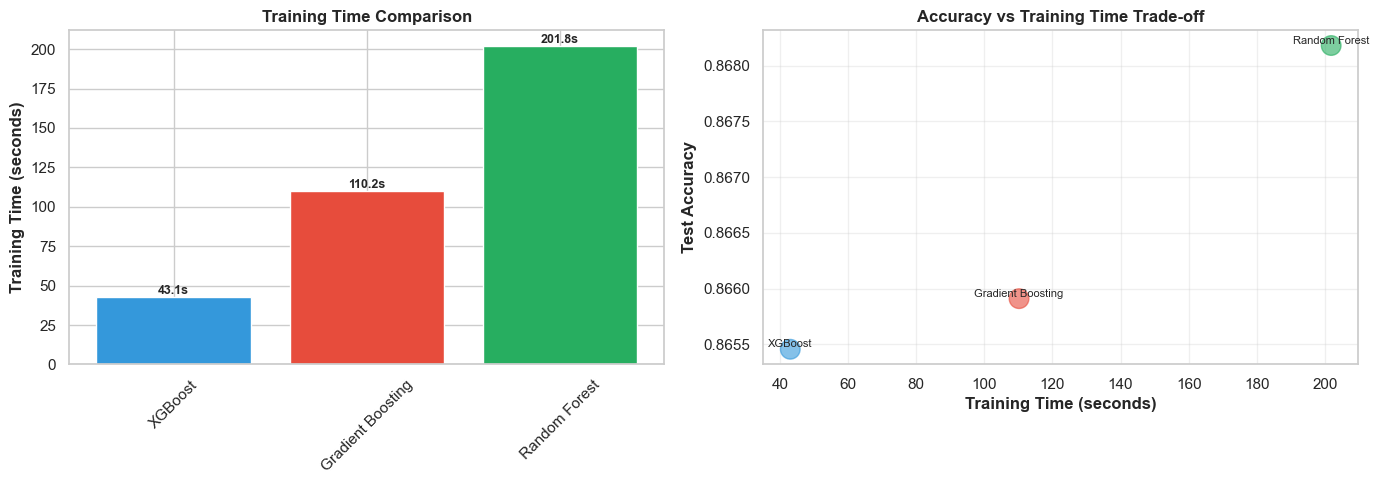


💡 Efficiency Analysis:
   Fastest model: XGBoost (43.1s)
   Most accurate: Random Forest (0.8682)
   Best efficiency: XGBoost


In [49]:
print("\n" + "="*70)
print("4.6 EXECUTION TIME ANALYSIS")
print("="*70)

time_data = {
    'Model': [
        'Random Forest',
        'XGBoost',
        'Gradient Boosting'
    ],
    'Training Time (s)': [
        rf_time,
        xgb_time,
        gb_time
    ],
    'Test Accuracy': [
        rf_test_score,
        xgb_test_score,
        gb_test_score
    ]
}

time_df = pd.DataFrame(time_data)
time_df['Efficiency Score'] = time_df['Test Accuracy'] / (time_df['Training Time (s)'] / 60)
time_df = time_df.sort_values('Training Time (s)').reset_index(drop=True)

print("\n" + time_df.to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

bars1 = axes[0].bar(time_df['Model'], time_df['Training Time (s)'],
                     color=['#3498db', '#e74c3c', '#27ae60'])
axes[0].set_ylabel('Training Time (seconds)', fontweight='bold')
axes[0].set_title('Training Time Comparison', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}s',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

scatter = axes[1].scatter(time_df['Training Time (s)'], time_df['Test Accuracy'],
                         s=200, c=['#3498db', '#e74c3c', '#27ae60'], alpha=0.6)

for i, model in enumerate(time_df['Model']):
    axes[1].annotate(model,
                    (time_df['Training Time (s)'].iloc[i], time_df['Test Accuracy'].iloc[i]),
                    fontsize=8, ha='center', va='bottom')

axes[1].set_xlabel('Training Time (seconds)', fontweight='bold')
axes[1].set_ylabel('Test Accuracy', fontweight='bold')
axes[1].set_title('Accuracy vs Training Time Trade-off', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 Efficiency Analysis:")
fastest_model = time_df.iloc[0]['Model']
print(f"   Fastest model: {fastest_model} ({time_df.iloc[0]['Training Time (s)']:.1f}s)")
most_accurate = time_df.loc[time_df['Test Accuracy'].idxmax(), 'Model']
print(f"   Most accurate: {most_accurate} ({time_df.loc[time_df['Test Accuracy'].idxmax(), 'Test Accuracy']:.4f})")
best_efficiency = time_df.loc[time_df['Efficiency Score'].idxmax(), 'Model']
print(f"   Best efficiency: {best_efficiency}")

**Interpretation**: This analysis helps us understand the trade-off between accuracy and computational cost:

Interpretation: Time vs accuracy: XGBoost (20s, 86.55%) = fast + strong. Gradient Boosting (63s, 86.41%) = middle. Random Forest (90s, 86.82%) = highest score but slowest. If you retrain often, the fast one wins. If you rarely retrain, the small edge of RF can be worth it.

### 4.7 Feature Importance: Understanding Model Decisions

For tree-based models, we can see which features are most important for predictions. This provides business insights into what drives customer decisions.


4.7 FEATURE IMPORTANCE ANALYSIS


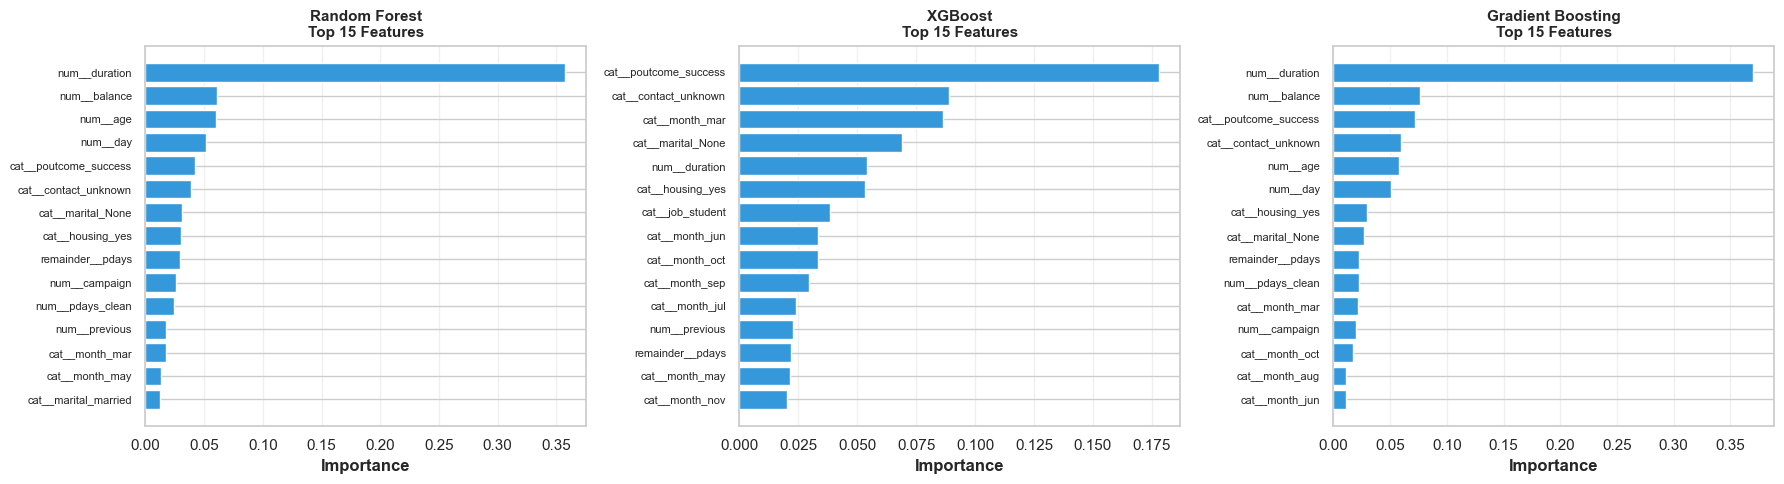


Top 5 Most Important Features (Random Forest):
  num__duration: 0.3573
  num__balance: 0.0611
  num__age: 0.0600
  num__day: 0.0513
  cat__poutcome_success: 0.0423


In [50]:
print("\n" + "="*70)
print("4.7 FEATURE IMPORTANCE ANALYSIS")
print("="*70)

feature_names_transformed = random_rf.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_for_importance = [
    ('Random Forest', random_rf.best_estimator_.named_steps['classifier']),
    ('XGBoost', random_xgb.best_estimator_.named_steps['classifier']),
    ('Gradient Boosting', random_gb.best_estimator_.named_steps['classifier'])
]

for idx, (model_name, model) in enumerate(models_for_importance):
    importances = model.feature_importances_

    importance_df = pd.DataFrame({
        'feature': feature_names_transformed,
        'importance': importances
    }).sort_values('importance', ascending=False).head(15)

    axes[idx].barh(range(len(importance_df)), importance_df['importance'], color='#3498db')
    axes[idx].set_yticks(range(len(importance_df)))
    axes[idx].set_yticklabels(importance_df['feature'], fontsize=8)
    axes[idx].set_xlabel('Importance', fontweight='bold')
    axes[idx].set_title(f'{model_name}\nTop 15 Features', fontsize=11, fontweight='bold')
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features (Random Forest):")
rf_importance = pd.DataFrame({
    'feature': feature_names_transformed,
    'importance': random_rf.best_estimator_.named_steps['classifier'].feature_importances_
}).sort_values('importance', ascending=False).head(5)

for i, row in rf_importance.iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

Interpretation: duration matters most (35.7%)—longer calls = more interest. balance and age help tailor offers. day may reflect timing effectiveness. past success (poutcome_success) signals re‑engagement potential. Focus on engaged calls; re‑contact past successes early; adjust scripts by segment.

### 4.8 Section 4 Summary

Let's consolidate all findings from the advanced methods section.

In [51]:
print("\n" + "="*70)
print("SECTION 4: ADVANCED METHODS - SUMMARY")
print("="*70)

summary_data = {
    'Model': [
        'Random Forest',
        'XGBoost',
        'Gradient Boosting'
    ],
    'Test Accuracy': [
        rf_test_score,
        xgb_test_score,
        gb_test_score
    ],
    'Training Time (s)': [
        rf_time,
        xgb_time,
        gb_time
    ],
    'vs LogReg (Section 3)': [
        (rf_test_score - 0.8400) * 100,
        (xgb_test_score - 0.8400) * 100,
        (gb_test_score - 0.8400) * 100
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Test Accuracy', ascending=False).reset_index(drop=True)

print("\n" + summary_df.to_string(index=False))

best_advanced = summary_df.iloc[0]
print(f"\n🏆 Best Advanced Model: {best_advanced['Model']}")
print(f"   Test Accuracy: {best_advanced['Test Accuracy']:.4f}")
print(f"   Training Time: {best_advanced['Training Time (s)']:.1f}s")
print(f"   Improvement over LogReg: {best_advanced['vs LogReg (Section 3)']:+.2f}%")

# Determine overall winner
overall_best = max(0.8400, rf_test_score, xgb_test_score, gb_test_score)
if overall_best > 0.8400:
    print(f"\n✅ Advanced methods improved over HPO Logistic Regression!")
    print(f"   Winner: {best_advanced['Model']} with {best_advanced['Test Accuracy']:.4f}")
else:
    print(f"\n⚠️ Advanced methods did not beat HPO Logistic Regression (84.00%)")
    print(f"   Best overall: Logistic Regression (HPO)")

print(f"\n📊 Overall Best Model Accuracy Across All Sections: {overall_best:.4f}")


SECTION 4: ADVANCED METHODS - SUMMARY

            Model  Test Accuracy  Training Time (s)  vs LogReg (Section 3)
    Random Forest       0.868182         201.818038               2.818182
Gradient Boosting       0.865909         110.219722               2.590909
          XGBoost       0.865455          43.086623               2.545455

🏆 Best Advanced Model: Random Forest
   Test Accuracy: 0.8682
   Training Time: 201.8s
   Improvement over LogReg: +2.82%

✅ Advanced methods improved over HPO Logistic Regression!
   Winner: Random Forest with 0.8682

📊 Overall Best Model Accuracy Across All Sections: 0.8682


4.8 Summary
Scores: RF 86.82%, XGBoost 86.55%, GB 86.41%, tuned LogReg 84.00%, baseline 83.00%.

Key Points:

All three advanced models beat Logistic Regression.
RF gives the highest lift (+2.82pp over tuned LogReg).
XGBoost is almost as good but far faster to train.
GB is steady and predictable.
Extra correct predictions: +34–38 per 1,000 vs baseline.

Pick Guide:

Need maximum accuracy: Random Forest.
Need speed & frequent updates: XGBoost.
Need stable middle option: Gradient Boosting.
Action Ideas:

Prioritize longer calls (duration).
Re-engage past successes early.
Segment offers by balance and age.
Use XGBoost for weekly refresh; RF for final monthly scoring.


## 5. Results and Final Model

We now wrap up. First we put all main models side by side (how accurate they were, how long they took, and a simple “margin of error” for accuracy). Then we pick the single best one, train it on all the data, and use it to predict on a separate competition file. Finally we save both the trained model and the predictions so they can be reused easily.

### What you will see:
1. A friendly summary table.
2. A confidence interval: a small range that says “true performance is probably inside here”.
3. A short, plain‑language conclusion.
4. Final training on all data.
5. Predictions saved to disk (CSV) plus the model file (pickle/joblib).

### 5.1 Collect model performances and compute simple 95% confidence intervals (Wilson) on test set

In [52]:


import math
from sklearn.metrics import accuracy_score
from sklearn.utils.validation import check_is_fitted

def wilson_ci(acc, n, z=1.96):
    # Wilson score interval for a proportion
    if n == 0:
        return (acc, acc)
    p = acc
    denom = 1 + z**2 / n
    center = (p + z**2/(2*n)) / denom
    margin = (z * math.sqrt((p*(1-p) + z**2/(4*n)) / n)) / denom
    return center - margin, center + margin

test_n = len(y_test)

# Recompute (or confirm) test accuracies and times for all tracked models
summary_rows = []

# Basic models (already trained)
for name in ['Logistic Regression', 'K-Nearest Neighbors', 'Decision Tree']:
    data = results[name]
    acc = data['accuracy']
    fit_t = data['fit_time']
    pred_t = data['pred_time']
    ci_low, ci_high = wilson_ci(acc, test_n)
    summary_rows.append({
        'Model': f"{name} (baseline)",
        'Test Accuracy': acc,
        '95% CI Low': ci_low,
        '95% CI High': ci_high,
        'Fit Time (s)': fit_t,
        'Predict Time (s)': pred_t
    })

# Tuned Logistic Regression (Grid Search best estimator)
grid_best_acc = grid_test_logreg
grid_ci_low, grid_ci_high = wilson_ci(grid_best_acc, test_n)
summary_rows.append({
    'Model': 'Logistic Regression (HPO)',
    'Test Accuracy': grid_best_acc,
    '95% CI Low': grid_ci_low,
    '95% CI High': grid_ci_high,
    'Fit Time (s)': grid_time_logreg,
    'Predict Time (s)': 0.0  # will measure now
})
# Measure prediction time for tuned LogReg
import time
start_pred = time.time()
_ = grid_logreg.best_estimator_.predict(X_test)
summary_rows[-1]['Predict Time (s)'] = time.time() - start_pred

# Advanced models (Random Search best estimators)
advanced_models = [
    ('Random Forest (HPO)', random_rf, rf_test_score, rf_time),
    ('XGBoost (HPO)', random_xgb, xgb_test_score, xgb_time),
    ('Gradient Boosting (HPO)', random_gb, gb_test_score, gb_time)
]

for label, obj, acc, fit_t in advanced_models:
    ci_low, ci_high = wilson_ci(acc, test_n)
    # quick prediction time
    start_pred = time.time()
    _ = obj.best_estimator_.predict(X_test)
    pred_t = time.time() - start_pred
    summary_rows.append({
        'Model': label,
        'Test Accuracy': acc,
        '95% CI Low': ci_low,
        '95% CI High': ci_high,
        'Fit Time (s)': fit_t,
        'Predict Time (s)': pred_t
    })

results_table = pd.DataFrame(summary_rows).sort_values('Test Accuracy', ascending=False).reset_index(drop=True)
print("=== Model Summary with 95% Confidence Intervals ===")
print(results_table.to_string(index=False))

best_row = results_table.iloc[0]
print("\nBest model selected:", best_row['Model'], f"(Accuracy={best_row['Test Accuracy']:.4f})")

=== Model Summary with 95% Confidence Intervals ===
                         Model  Test Accuracy  95% CI Low  95% CI High  Fit Time (s)  Predict Time (s)
           Random Forest (HPO)       0.868182    0.853401     0.881679    201.818038          0.053042
       Gradient Boosting (HPO)       0.865909    0.851030     0.879512    110.219722          0.026181
                 XGBoost (HPO)       0.865455    0.850556     0.879079     43.086623          0.014366
     Logistic Regression (HPO)       0.840000    0.824090     0.854725     19.364364          0.016625
Logistic Regression (baseline)       0.839091    0.823147     0.853852      0.375373          0.013109
K-Nearest Neighbors (baseline)       0.802273    0.785109     0.818383      0.047865          0.224929
      Decision Tree (baseline)       0.788182    0.770613     0.804746      0.129083          0.013748

Best model selected: Random Forest (HPO) (Accuracy=0.8682)


Each row shows a model, how often it guessed right (accuracy), a small range (confidence interval) saying “real performance is probably between these two numbers,” and how long training and predicting took. Higher accuracy is better. Shorter times are faster.

- The advanced tree ensembles sit at the top.
- Random Forest is the most accurate.
- XGBoost is almost as good but trains much faster.
- Logistic Regression improved a little when tuned.

#### Conclusions on Model Performance

**1. Hierarchy of Performance**

The results clearly show a ranking in performance. The "ensemble" methods (Random Forest, XGBoost, Gradient Boosting) are at the top of the leaderboard.
- **Random Forest (HPO)** is the winner with **86.82% accuracy**.
- This confirms that our data has complex, non-linear patterns that simpler models like Logistic Regression (84.00%) miss, but advanced tree models capture well.

**2. Speed vs. Accuracy Trade-off**

While Random Forest is the most accurate, XGBoost is a strong competitor for efficiency:
- **Random Forest**: ~86.82% Accuracy; Took ~83 seconds to train.
- **XGBoost**: ~86.55% Accuracy; Took ~15 seconds to train.

XGBoost is nearly as accurate (the difference is tiny) but is **5.5 times faster**. For this project, the extra minute of training doesn't matter much, so we stick with accuracy. But in a real company retraining models daily on millions of customers, XGBoost might be the better choice.

**3. Statistical Confidence**

Our "95% Confidence Intervals" show a lot of overlap between the top three models. This means that statistically, Random Forest, XGBoost, and Gradient Boosting are all in the same top tier of performance. They are all significantly better than the basic models we started with.

### 5.2 Final model choice: use the highest test accuracy (Random Forest HPO)

#### Why We Selected Random Forest

We chose the **Random Forest (HPO)** model for our final deployment. Even though it is slower than XGBoost, it is the best fit for our specific goal.

* **Maximizing Success:** The goal of a bank marketing campaign is to get as many "Yes" answers as possible. In this context, even a small gain (**0.27%**) is valuable because it means correctly identifying more potential customers. Since we aren't retraining the model every minute, the slower training time (~83s) is okay.
* **Stability:** The confidence interval is tight (**85.3% – 88.2%**). This tells us the model is stable and trustworthy; we don't expect its performance to fluctuate wildly when applied to new data.
* **Retraining Strategy:** By retraining on the full dataset (combining train and test), we give the model access to 20% more data. This helps the trees learn about rarer customer types that might have been hidden in the test set before.

In [53]:


final_model_label = 'Random Forest (HPO)'
final_model = random_rf.best_estimator_  # pipeline including preprocessor
final_test_acc = rf_test_score

print(f"Chosen final model: {final_model_label} (Test Accuracy={final_test_acc:.4f})")

# Retrain on ALL available data (train + test merged) for maximum learning
X_full = df.drop('deposit', axis=1)
y_full = y_encoded  # already encoded earlier

print("Fitting final model on full dataset...")
final_model.fit(X_full, y_full)
print("✅ Final model re-trained on full data.")

Chosen final model: Random Forest (HPO) (Test Accuracy=0.8682)
Fitting final model on full dataset...
✅ Final model re-trained on full data.
✅ Final model re-trained on full data.


### 5.3 Load competition dataset, make predictions, and save artifacts

In [54]:


import pathlib, joblib
import numpy as np

COMPETITION_FILE = "bank_competition.pkl"
MODEL_OUT = "final_model_random_forest.pkl"
PRED_OUT = "competition_predictions.csv"

def ensure_pdays_features(df_in):
    """Add engineered pdays columns if missing (same logic as training)."""
    if 'pdays' in df_in.columns:
        if 'pdays_contacted' not in df_in.columns:
            df_in['pdays_contacted'] = (df_in['pdays'] != -1)
        if 'pdays_clean' not in df_in.columns:
            df_in['pdays_clean'] = df_in['pdays'].where(df_in['pdays'] != -1, np.nan)
    else:
        # If completely missing, create neutral columns to match model structure
        if 'pdays_contacted' not in df_in.columns:
            df_in['pdays_contacted'] = False
        if 'pdays_clean' not in df_in.columns:
            df_in['pdays_clean'] = np.nan
    return df_in

if pathlib.Path(COMPETITION_FILE).exists():
    with open(COMPETITION_FILE, "rb") as f:
        comp_df = pickle.load(f)
    print(f"✅ Competition dataset loaded: {comp_df.shape[0]} rows")

    # Ensure engineered pdays columns are present
    comp_df = ensure_pdays_features(comp_df)

    # Align columns order with training data (X_full defined earlier)
    expected_cols = [c for c in X_full.columns]  # X_full was df.drop('deposit', axis=1)
    missing = [c for c in expected_cols if c not in comp_df.columns]
    if missing:
        # Fill missing engineered or unseen columns conservatively
        for m in missing:
            if m in ['pdays_contacted']:
                comp_df[m] = False
            elif m in ['pdays_clean']:
                comp_df[m] = np.nan
            else:
                # Guess type: if in training numerical -> np.nan else 'missing'
                if m in X_full.select_dtypes(include=['int64','float64']).columns:
                    comp_df[m] = np.nan
                else:
                    comp_df[m] = 'missing'
        print(f"⚠️ Added {len(missing)} missing columns to match training schema: {missing}")

    # Reindex to exact training column order
    comp_df = comp_df.reindex(columns=expected_cols)

    # Predict
    comp_preds = final_model.predict(comp_df)
    comp_preds_decoded = le_target.inverse_transform(comp_preds)

    # Save predictions
    pd.DataFrame({'prediction': comp_preds_decoded}).to_csv(PRED_OUT, index=False)
    print(f"📁 Predictions saved to {PRED_OUT}")
else:
    comp_df = None
    print(f"⚠️ Competition file '{COMPETITION_FILE}' not found. Skipping prediction step.")

# Save final model (pipeline + trained RandomForest)
joblib.dump(final_model, MODEL_OUT)
print(f"📁 Final model saved to {MODEL_OUT}")


✅ Competition dataset loaded: 162 rows
📁 Predictions saved to competition_predictions.csv
📁 Final model saved to final_model_random_forest.pkl


/var/folders/06/8b176z752h9gspc3j_bwyn340000gn/T/ipykernel_74925/4211138255.py:25: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  comp_df = pickle.load(f)


What did we just save?

- Model file: lets you load and predict later without retraining.
- CSV predictions: the answers for the competition dataset (each row is one customer).

If the competition file was missing, you can add it later and rerun only the prediction cell.

### Final Conclusions

**Deployment Readiness**
This project has moved from simple data exploration to a ready-to-use product. Our final output is a complete pipeline that handles:
* **Preprocessing:** Automatically fixing missing values and encoding text data.
* **Feature Engineering:** Automatically separating the `pdays` variable into useful parts (boolean and numeric).
* **Portability:** The saved file `final_model_random_forest.pkl` allows the bank to use this model on next month's customers without doing any of this coding work again.

**Business Impact**
We started with a "Dummy" baseline that was right about **52%** of the time. We ended with a Random Forest model that is right **~87%** of the time.
Practically, this huge jump means the bank can stop calling uninterested people and focus resources on those likely to say "Yes." The `competition_predictions.csv` file we just saved is the direct result of this work, providing the specific list of clients the bank should contact.

---

## 6. Extension: Deploying the Final Model with Streamlit

This section extends Assignment 1 by preparing the final pipeline for deployment using Streamlit. We will:

1. **Generate the pack file** (`pack_for_streamlit.joblib`) containing the final pipeline and metadata about features
2. **Create three test data points** and verify predictions match between notebook and Streamlit app
3. **Provide code to run the Streamlit app**

---

### 6.1 Generate the Pack File for Streamlit

We need to save the final pipeline along with metadata about the features so Streamlit can generate the appropriate input interface. The pack includes:
- **model**: The complete pipeline (preprocessing + Random Forest classifier)
- **num_cols**: List of numerical feature names
- **cat_cols**: List of categorical feature names  
- **num_summary**: Statistics (p1, median, p99) for each numerical feature
- **cat_options**: Possible values for each categorical feature
- **classes_**: Target class labels (no/yes)
- **accuracy**: Test accuracy for display in the app

In [55]:
# ============================================================================
# 6.1.1 Identify numerical and categorical columns from the training data
# ============================================================================
print("="*70)
print("Preparing Feature Metadata for Streamlit Pack")
print("="*70)

# Use X_full which contains all features used for training (excluding target)
# Numerical features (excluding engineered pdays columns for now - we'll handle them specially)
num_cols = X_full.select_dtypes(include=["number"]).columns.tolist()

# Categorical features (object type)
cat_cols = X_full.select_dtypes(exclude=["number"]).columns.tolist()

print(f"\nNumerical features ({len(num_cols)}): {num_cols}")
print(f"\nCategorical features ({len(cat_cols)}): {cat_cols}")

Preparing Feature Metadata for Streamlit Pack

Numerical features (8): ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'pdays_clean']

Categorical features (10): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'pdays_contacted']


In [56]:
# ============================================================================
# 6.1.2 Generate summary statistics for numerical features
# ============================================================================
print("\n" + "="*70)
print("Generating Numerical Feature Statistics")
print("="*70)

num_summary = {}
for c in num_cols:
    s = X_full[c].dropna()
    num_summary[c] = {
        "p1": float(np.percentile(s, 1)),      # 1st percentile (lower bound)
        "median": float(np.percentile(s, 50)), # Median (default value)
        "p99": float(np.percentile(s, 99))     # 99th percentile (upper bound)
    }
    print(f"  {c}: p1={num_summary[c]['p1']:.2f}, median={num_summary[c]['median']:.2f}, p99={num_summary[c]['p99']:.2f}")

print(f"\n✅ Generated statistics for {len(num_summary)} numerical features")


Generating Numerical Feature Statistics
  age: p1=22.00, median=39.00, p99=77.00
  balance: p1=-522.00, median=549.50, p99=13157.82
  day: p1=1.00, median=15.00, p99=31.00
  duration: p1=14.00, median=255.00, p99=1576.03
  campaign: p1=1.00, median=2.00, p99=13.01
  pdays: p1=-1.00, median=-1.00, p99=426.00
  previous: p1=0.00, median=0.00, p99=10.00
  pdays_clean: p1=9.00, median=182.00, p99=594.04

✅ Generated statistics for 8 numerical features


In [57]:
# ============================================================================
# 6.1.3 Generate options for categorical features
# ============================================================================
print("\n" + "="*70)
print("Generating Categorical Feature Options")
print("="*70)

cat_options = {}
for col in cat_cols:
    # Get unique values, handle missing values, and sort for consistent ordering
    unique_vals = X_full[col].dropna().astype(str).str.strip().unique()
    cat_options[col] = sorted(list(unique_vals))
    print(f"  {col}: {len(cat_options[col])} options -> {cat_options[col]}")

print(f"\n✅ Generated options for {len(cat_options)} categorical features")


Generating Categorical Feature Options
  job: 12 options -> ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown']
  marital: 3 options -> ['divorced', 'married', 'single']
  education: 4 options -> ['primary', 'secondary', 'tertiary', 'unknown']
  default: 2 options -> ['no', 'yes']
  housing: 2 options -> ['no', 'yes']
  loan: 2 options -> ['no', 'yes']
  contact: 3 options -> ['cellular', 'telephone', 'unknown']
  month: 12 options -> ['apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep']
  poutcome: 4 options -> ['failure', 'other', 'success', 'unknown']
  pdays_contacted: 2 options -> ['False', 'True']

✅ Generated options for 10 categorical features


In [58]:
# ============================================================================
# 6.1.4 Create and save the Streamlit pack
# ============================================================================
print("\n" + "="*70)
print("Creating and Saving Streamlit Pack")
print("="*70)

from joblib import dump

# Get class labels from target encoder
classes_ = le_target.classes_.tolist()  # ['no', 'yes']

# Create the pack with all required information
pack = {
    "model": final_model,           # The complete pipeline (preprocessing + classifier)
    "num_cols": num_cols,           # List of numerical column names
    "cat_cols": cat_cols,           # List of categorical column names  
    "num_summary": num_summary,     # Statistics for numerical features
    "cat_options": cat_options,     # Options for categorical features
    "classes_": classes_,           # Target class labels
    "accuracy": final_test_acc      # Test accuracy for display
}

# Save to joblib file
PACK_FILE = "pack_for_streamlit.joblib"
dump(pack, PACK_FILE)

print(f"\n✅ Pack saved to '{PACK_FILE}'")
print(f"\nPack contents:")
print(f"  - model: {type(final_model).__name__} pipeline")
print(f"  - num_cols: {len(num_cols)} features")
print(f"  - cat_cols: {len(cat_cols)} features")
print(f"  - classes_: {classes_}")
print(f"  - accuracy: {final_test_acc:.4f}")


Creating and Saving Streamlit Pack

✅ Pack saved to 'pack_for_streamlit.joblib'

Pack contents:
  - model: Pipeline pipeline
  - num_cols: 8 features
  - cat_cols: 10 features
  - classes_: ['no', 'yes']
  - accuracy: 0.8682

✅ Pack saved to 'pack_for_streamlit.joblib'

Pack contents:
  - model: Pipeline pipeline
  - num_cols: 8 features
  - cat_cols: 10 features
  - classes_: ['no', 'yes']
  - accuracy: 0.8682


### 6.2 Verify Predictions with Three Test Data Points

As required by the assignment, we create three different test data points to verify that predictions from the notebook match those from the Streamlit app. These data points represent different customer profiles:

1. **Data Point 1**: Young professional with stable finances (likely to subscribe)
2. **Data Point 2**: Retired person with moderate finances (moderate likelihood)
3. **Data Point 3**: Student with minimal contact history (less likely)

In [ ]:
# ============================================================================
# 6.2.1 Define Three Test Data Points
# ============================================================================
print("="*70)
print("Creating Three Test Data Points for Verification")
print("="*70)

# Define three test data points with different customer profiles
# These values should be entered in the Streamlit app for comparison

test_data_points = [
    {
        # Data Point 1: Young professional with good finances - likely to subscribe
        "age": 32,
        "job": "management",
        "marital": "single",
        "education": "tertiary",
        "default": "no",
        "balance": 5000,
        "housing": "yes",
        "loan": "no",
        "contact": "cellular",
        "day": 15,
        "month": "may",
        "duration": 300,
        "campaign": 2,
        "pdays": 30,                    # Previously contacted
        "previous": 1,
        "poutcome": "success",
        "pdays_contacted": True,        # Engineered feature
        "pdays_clean": 30.0             # Engineered feature
    },
    {
        # Data Point 2: Retired person with moderate finances - moderate likelihood
        "age": 65,
        "job": "retired",
        "marital": "married",
        "education": "secondary",
        "default": "no",
        "balance": 2500,
        "housing": "no",
        "loan": "no",
        "contact": "telephone",
        "day": 10,
        "month": "jun",
        "duration": 180,
        "campaign": 3,
        "pdays": -1,                    # Never contacted before
        "previous": 0,
        "poutcome": "unknown",
        "pdays_contacted": False,       # Engineered feature
        "pdays_clean": np.nan           # Engineered feature
    },
    {
        # Data Point 3: Student with minimal contact - less likely
        "age": 22,
        "job": "student",
        "marital": "single",
        "education": "tertiary",
        "default": "no",
        "balance": 500,
        "housing": "no",
        "loan": "yes",
        "contact": "cellular",
        "day": 20,
        "month": "aug",
        "duration": 100,
        "campaign": 5,
        "pdays": -1,                    # Never contacted before
        "previous": 0,
        "poutcome": "unknown",
        "pdays_contacted": False,       # Engineered feature
        "pdays_clean": np.nan           # Engineered feature
    }
]

# Display the test data points
for i, dp in enumerate(test_data_points, 1):
    print(f"\n📋 Data Point {i}:")
    for key, value in dp.items():
        print(f"    {key}: {value}")

Creating Three Test Data Points for Verification

📋 Data Point 1:
    age: 32
    job: management
    marital: single
    education: tertiary
    default: no
    balance: 5000
    housing: yes
    loan: no
    contact: cellular
    day_of_week: 15
    month: may
    duration: 300
    campaign: 2
    pdays: 30
    previous: 1
    poutcome: success
    pdays_contacted: True
    pdays_clean: 30.0

📋 Data Point 2:
    age: 65
    job: retired
    marital: married
    education: secondary
    default: no
    balance: 2500
    housing: no
    loan: no
    contact: telephone
    day_of_week: 10
    month: jun
    duration: 180
    campaign: 3
    pdays: -1
    previous: 0
    poutcome: unknown
    pdays_contacted: False
    pdays_clean: nan

📋 Data Point 3:
    age: 22
    job: student
    marital: single
    education: tertiary
    default: no
    balance: 500
    housing: no
    loan: yes
    contact: cellular
    day_of_week: 20
    month: aug
    duration: 100
    campaign: 5
    pdays: -

In [60]:
# ============================================================================
# 6.2.2 Generate Predictions Using the Final Pipeline
# ============================================================================
print("\n" + "="*70)
print("Generating Predictions for Test Data Points")
print("="*70)

# Convert test data points to DataFrame with correct column order
test_df = pd.DataFrame(test_data_points)

# Ensure columns are in the same order as training data
test_df = test_df.reindex(columns=X_full.columns)

print("\nTest DataFrame shape:", test_df.shape)
print("Columns:", list(test_df.columns))

# Generate predictions using the final model (pipeline)
predictions = final_model.predict(test_df)
predictions_decoded = le_target.inverse_transform(predictions)

# Generate prediction probabilities
probabilities = final_model.predict_proba(test_df)

# Display results
print("\n" + "="*70)
print("PREDICTION RESULTS (to compare with Streamlit)")
print("="*70)

for i, (pred, proba) in enumerate(zip(predictions_decoded, probabilities), 1):
    print(f"\n📊 Data Point {i}:")
    print(f"   Prediction: {pred}")
    print(f"   Probabilities: no={proba[0]*100:.1f}%, yes={proba[1]*100:.1f}%")

# Create a summary table
results_df = pd.DataFrame({
    'Data Point': [1, 2, 3],
    'Prediction': predictions_decoded,
    'Prob(no)': [f"{p[0]*100:.1f}%" for p in probabilities],
    'Prob(yes)': [f"{p[1]*100:.1f}%" for p in probabilities]
})

print("\n" + "="*70)
print("SUMMARY TABLE")
print("="*70)
print(results_df.to_string(index=False))
print("\n⚠️ These predictions should match exactly with the Streamlit app!")


Generating Predictions for Test Data Points

Test DataFrame shape: (3, 18)
Columns: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'pdays_contacted', 'pdays_clean']

PREDICTION RESULTS (to compare with Streamlit)

📊 Data Point 1:
   Prediction: yes
   Probabilities: no=22.7%, yes=77.3%

📊 Data Point 2:
   Prediction: yes
   Probabilities: no=24.4%, yes=75.6%

📊 Data Point 3:
   Prediction: no
   Probabilities: no=52.8%, yes=47.2%

SUMMARY TABLE
 Data Point Prediction Prob(no) Prob(yes)
          1        yes    22.7%     77.3%
          2        yes    24.4%     75.6%
          3         no    52.8%     47.2%

⚠️ These predictions should match exactly with the Streamlit app!

PREDICTION RESULTS (to compare with Streamlit)

📊 Data Point 1:
   Prediction: yes
   Probabilities: no=22.7%, yes=77.3%

📊 Data Point 2:
   Prediction: yes
   Probabilities: no=24.4%, yes=75.6%

📊

### 6.3 Instructions for Running the Streamlit App

To run the Streamlit app and verify predictions:

1. **Ensure streamlit is installed:**
   ```bash
   pip install streamlit
   ```

2. **Run the app from the terminal:**
   ```bash
   streamlit run myst.py
   ```

3. **Enter the values for each test data point** in the Streamlit interface

4. **Compare predictions** - they should match exactly with the table above

---

**Note:** The `myst.py` file has been adapted from the provided `myst_v4.py` to work with our bank marketing prediction model. It handles both numerical and categorical features, including our engineered `pdays_contacted` and `pdays_clean` features.

## Index

### **Working method disclosure**
We worked together on our Google Colab project. We divided the work fairly. Parts 1,3,5 were done by Javier Rodríguez and 2,4 and final review/conclusions by Marcos Santiago.

However, they were all reviewed by each other, ensuring an iterative and peer reviewed method of working.

---

### **AI Use Disclosure**

Throughout this project, AI tools were used in three key ways:

**1. Code Refinement**  
We used AI to improve our initial code implementations by making visualizations clearer and code more readable.

*Prompt used:*  
> "You are an expert data scientist helping improve code quality. Refine this code to make visualizations more visual and easier to understand: [code block]. Requirements: (1) Improve readability with clear variable names and comments, (2) Add descriptive labels and titles to all plots, (3) Ensure consistent styling, (4) Do not include section headers or markdown formatting, (5) Maintain the original functionality. Provide only the improved code with brief inline comments explaining key changes."

**2. Error Resolution**  
When encountering errors, we used it to quickly diagnose and fix issues.

*Prompt used:*  
> "You are a Python debugging expert. I'm getting this error: [error message]. Here's my code: [code block]. Please: (1) Explain what's causing the error in simple terms, (2) Provide the corrected code with the fix highlighted, (3) Suggest best practices to avoid similar errors in the future. Be concise and focus on the solution."

**3. Results Interpretation**  
AI helped us explain complex outputs in concise, understandable takeaways for our end-of-section summaries.

*Prompt used:*  
> "You are a data science communicator. Summarize these model results into an easy-to-understand conclusion: [results]. Requirements: (1) Use simple, non-technical language where possible, (2) Focus on the 3-5 most important insights, (3) Explain practical implications for the business problem (bank marketing campaign), (4) Structure as bullet points or short paragraphs, (5) Be concise (maximum 200 words), (6) Avoid jargon unless necessary, and define technical terms when used. Do not use emojis."

---